In [1]:
#!pip install nibabel==3.2.2

In [2]:
#!pip install nilearn

In [6]:
#!pip install imutils

  Using cached imutils-0.5.4-py3-none-any.whl


In [15]:
#import imutils

In [1]:
#import asyncio

#try:
 #   asyncio.get_event_loop()
#except RuntimeError:
 #   asyncio.set_event_loop(asyncio.new_event_loop())

In [4]:
#pip install seaborn

Note: you may need to restart the kernel to use updated packages.


Importing necessary library 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import glob
import nibabel as nib
from pathlib import Path
import os, sys, tarfile
import cv2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from nilearn.maskers import NiftiMasker, NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.plotting import plot_stat_map, show
from nilearn.image import index_img
from nilearn.image.image import mean_img
from nilearn import image as nimg
from nilearn import plotting as nplot
from imutils import paths
import pandas as pd
from keras.layers import Dense,Dropout,BatchNormalization,Flatten
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import classification_report,confusion_matrix
from keras.optimizers import Adam
from sklearn import svm
import pickle

Dataset Preparation

In [3]:
def extract(tar_url, extract_path='.'):
    tar = tarfile.open(tar_url, 'r')
    for item in tar:
        tar.extract(item, extract_path)
        if item.name.find(".tgz") != -1 or item.name.find(".tar") != -1:
            extract(item.name, "./" + item.name[:item.name.rfind('/')])
try:

    extract(sys.argv[1] + '.tgz')
    print('Done.')
except:
    name = os.path.basename(sys.argv[0])
    print(name[:name.rfind('.')], '<filename>')

ipykernel_launcher <filename>


In [3]:
# # extracting caltech tgz file
#extract('E:/FYP-2023/Caltech.tgz','E:/FYP-2023/')

# # extracting Sdsu tgz file
#extract('E:/FYP-2023/SDSU.tgz','E:/FYP-2023/')

# #extracting Olin tgz file
#extract('E:/FYP-2023/Olin.tgz','E:/FYP-2023/')

# #extracting Stanford tgz file
#extract('E:/FYP-2023/Stanford.tgz','E:/FYP-2023/')

# # extracting ohsu tgz file
#extract('E:/FYP-2023/OHSU.tgz','E:/FYP-2023/')

# #extracting SBL tgz file
#extract('E:/FYP-2023/SBL.tgz','E:/FYP-2023/')

# # extracting trinity tgz file
#extract('E:/FYP-2023/Trinity.tgz','E:/FYP-2023/')

# #extracting Yale tgz file
#extract('E:/FYP-2023/Yale.tgz','E:/FYP-2023/')

# #extracting pitt tgz file
#extract('E:/FYP-2023/Pitt.tgz','E:/FYP-2023/')

# #extracting USM tgz file
#extract('E:/FYP-2023/USM.tgz','E:/FYP-2023/')

# #extracting KKI tgz file
#extract('E:/FYP-2023/KKI.tgz','E:/FYP-2023/')

# #extracting UCLA_1 tgz file
#extract('E:/FYP-2023/UCLA_1.tgz','E:/FYP-2023/')

# #extracting UCLA_2 tgz file
#extract('E:/FYP-2023/UCLA_2.tgz','E:/FYP-2023/')

In [4]:
file_path = glob.glob('E:/FYP-2023/*/*/*/*/*.gz')
print(len(file_path))

1419


In [5]:
#img1=nib.load("E:/FYP-2023/SDSU/0050182/session_1/rest_1/rest.nii.gz").get_fdata()
img1=nib.load(file_path[1]).get_fdata()
print(img1.max())
sc=MinMaxScaler()
imageR=sc.fit_transform(img1.reshape(-1, img1.shape[-1])).reshape(img1.shape)

1763.0


In [6]:
imageR=np.moveaxis(imageR[:,:,0],-1,0)

In [7]:
imageR.shape

(150, 64, 64)

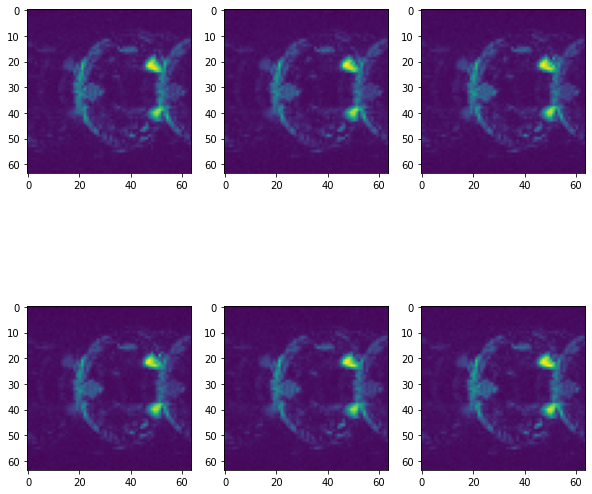

In [8]:
plt.figure(figsize=(10,10))
plt.subplot(231)
plt.imshow(imageR[25])
#plt.imshow(imageR[180])
plt.subplot(232)
plt.imshow(imageR[50])
plt.subplot(233)
plt.imshow(imageR[75])
plt.subplot(234)
plt.imshow(imageR[100])
plt.subplot(235)
plt.imshow(imageR[125])
plt.subplot(236)
plt.imshow(imageR[130])
plt.show()

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\image\resampling.py:545: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


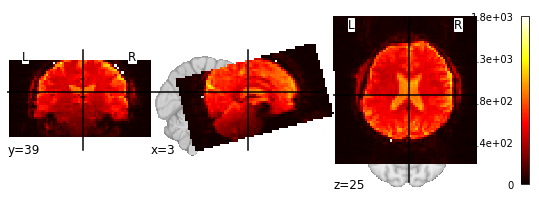

In [9]:
from nilearn import plotting, image

# Load the 4D fMRI image
#fmri_img = image.load_img("E:/FYP-2023/Caltech/0051456/session_1/rest_1/rest.nii.gz")
fmri_img = image.load_img(file_path[1])

# Extract the first volume from the 4D image
volume_img = image.index_img(fmri_img, 0)

# Plot the 3D volume
plotting.plot_stat_map(volume_img, display_mode='ortho')


Functional connectivity

In [10]:
# Caltech dataset separate autism and control
# Load the phenotypic csv file
csv_file = 'E:/FYP-2023/phenotypic_CALTECH.csv'
phenotypic_caltech = pd.read_csv(csv_file)


df_data = phenotypic_caltech[['SUB_ID', 'DX_GROUP',"AGE_AT_SCAN","SEX"]]
names_to_drop = [51457,51458,51462,51463,51464,51468,51469,51472,51470,51475,51482,51487,51491]

df_data = df_data.loc[~df_data['SUB_ID'].isin(names_to_drop)]
# Select the autism and control groups based on their diagnosis in the phenotypic data
autism_group_caltech = df_data.loc[df_data['DX_GROUP'] == 1]
control_group_caltech = df_data.loc[df_data['DX_GROUP'] == 2]

autism_group_id = autism_group_caltech["SUB_ID"].tolist()
control_group_id = control_group_caltech["SUB_ID"].tolist()

autism_rest_caltech = ['E:/FYP-2023/Caltech/00%s/session_1/rest_1/rest.nii.gz' %(sub) for sub in autism_group_id]
control_rest_caltech =  ['E:/FYP-2023/Caltech/00%s/session_1/rest_1/rest.nii.gz' %(sub) for sub in control_group_id]


In [11]:
# Sdsu dataset separate autism and control
# Load the phenotypic csv file
csv_file = 'E:/FYP-2023/phenotypic_SDSU.csv'
phenotypic_sdsu = pd.read_csv(csv_file)

df_data1 = phenotypic_sdsu[['SUB_ID', 'DX_GROUP',"AGE_AT_SCAN","SEX"]]

# Select the autism and control groups based on their diagnosis in the phenotypic data
autism_group_sdsu = df_data1.loc[df_data1['DX_GROUP'] == 1]
control_group_sdsu = df_data1.loc[df_data1['DX_GROUP'] == 2]

autism_group_id = autism_group_sdsu["SUB_ID"].tolist()
control_group_id = control_group_sdsu["SUB_ID"].tolist()

autism_rest_sdsu = ['E:/FYP-2023/SDSU/00%s/session_1/rest_1/rest.nii.gz' %(sub) for sub in autism_group_id]
control_rest_sdsu = ['E:/FYP-2023/SDSU/00%s/session_1/rest_1/rest.nii.gz' %(sub) for sub in control_group_id]

In [12]:
# olin dataset separate autism and control
# Load the phenotypic olin csv file
csv_file = 'E:/FYP-2023/Phenotypic_OLIN.csv'
phenotypic_olin = pd.read_csv(csv_file)

df_data2 = phenotypic_olin[['SUB_ID', 'DX_GROUP',"AGE_AT_SCAN","SEX"]]

# Select the autism and control groups based on their diagnosis in the phenotypic data
autism_group_olin = df_data2.loc[df_data2['DX_GROUP'] == 1]
control_group_olin = df_data2.loc[df_data2['DX_GROUP'] == 2]

autism_group_id = autism_group_olin["SUB_ID"].tolist()
control_group_id = control_group_olin["SUB_ID"].tolist()

autism_rest_olin= ['E:/FYP-2023/Olin/00%s/session_1/rest_1/rest.nii.gz' %(sub) for sub in autism_group_id]
control_rest_olin = ['E:/FYP-2023/Olin/00%s/session_1/rest_1/rest.nii.gz' %(sub) for sub in control_group_id]

In [13]:
# Stanford dataset separate autism and control
# Load the phenotypic stanford csv file
csv_file = 'E:/FYP-2023/phenotypic_STANFORD.csv'
phenotypic_stanford = pd.read_csv(csv_file)


df_data3 = phenotypic_stanford[['SUB_ID', 'DX_GROUP',"AGE_AT_SCAN","SEX"]]

name_to_drop = [51191,51194,51198]

df_data3 = df_data3.loc[~df_data3['SUB_ID'].isin(name_to_drop)]
# Select the autism and control groups based on their diagnosis in the phenotypic data
autism_group_stanford = df_data3.loc[df_data3['DX_GROUP'] == 1]
control_group_stanford = df_data3.loc[df_data3['DX_GROUP'] == 2]

autism_group_id = autism_group_stanford["SUB_ID"].tolist()
control_group_id = control_group_stanford["SUB_ID"].tolist()

autism_rest_stanford = ['E:/FYP-2023/Stanford/00%s/session_1/rest_1/rest.nii.gz' %(sub) for sub in autism_group_id]
control_rest_stanford = ['E:/FYP-2023/Stanford/00%s/session_1/rest_1/rest.nii.gz' %(sub) for sub in control_group_id]

In [14]:
# OHSU dataset separate autism and control
# Load the phenotypic stanford csv file
csv_file = 'E:/FYP-2023/phenotypic_OHSU.csv'
phenotypic_ohsu = pd.read_csv(csv_file)

df_data4 = phenotypic_ohsu[['SUB_ID', 'DX_GROUP',"AGE_AT_SCAN","SEX"]]

name_to_drop = [50155,50165]

df_data4 = df_data4.loc[~df_data4['SUB_ID'].isin(name_to_drop)]
# Select the autism and control groups based on their diagnosis in the phenotypic data
autism_group_ohsu = df_data4.loc[df_data4['DX_GROUP'] == 1]
control_group_ohsu = df_data4.loc[df_data4['DX_GROUP'] == 2]

autism_group_id = autism_group_ohsu["SUB_ID"].tolist()
control_group_id = control_group_ohsu["SUB_ID"].tolist()

autism_rest_ohsu = ['E:/FYP-2023/OHSU/00%s/session_1/rest_1/rest.nii.gz' %(sub) for sub in autism_group_id]
control_rest_ohsu = ['E:/FYP-2023/OHSU/00%s/session_1/rest_1/rest.nii.gz' %(sub) for sub in control_group_id]

In [15]:
# SBL dataset separate autism and control
# Load the phenotypic sbl csv file
csv_file = 'E:/FYP-2023/phenotypic_SBL.csv'
phenotypic_sbl = pd.read_csv(csv_file)

df_data5 = phenotypic_sbl[['SUB_ID', 'DX_GROUP',"AGE_AT_SCAN","SEX"]]
# Select the autism and control groups based on their diagnosis in the phenotypic data
autism_group_sbl = df_data5.loc[df_data5['DX_GROUP'] == 1]
control_group_sbl = df_data5.loc[df_data5['DX_GROUP'] == 2]

autism_group_id = autism_group_sbl["SUB_ID"].tolist()
control_group_id = control_group_sbl["SUB_ID"].tolist()

autism_rest_sbl = ['E:/FYP-2023/SBL/00%s/session_1/rest_1/rest.nii.gz' %(sub) for sub in autism_group_id]
control_rest_sbl = ['E:/FYP-2023/SBL/00%s/session_1/rest_1/rest.nii.gz' %(sub) for sub in control_group_id]

In [16]:
# Trinity dataset separate autism and control
# Load the phenotypic trinity csv file
csv_file = 'E:/FYP-2023/phenotypic_TRINITY.csv'
phenotypic_ohsu = pd.read_csv(csv_file)

df_data6 = phenotypic_ohsu[['SUB_ID', 'DX_GROUP',"AGE_AT_SCAN","SEX"]]

# Select the autism and control groups based on their diagnosis in the phenotypic data
autism_group_trinity = df_data6.loc[df_data6['DX_GROUP'] == 1]
control_group_trinity = df_data6.loc[df_data6['DX_GROUP'] == 2]

autism_group_id = autism_group_trinity["SUB_ID"].tolist()
control_group_id = control_group_trinity["SUB_ID"].tolist()

autism_rest_trinity = ['E:/FYP-2023/Trinity/00%s/session_1/rest_1/rest.nii.gz' %(sub) for sub in autism_group_id]
control_rest_trinity = ['E:/FYP-2023/Trinity/00%s/session_1/rest_1/rest.nii.gz' %(sub) for sub in control_group_id]

In [17]:
# Yale dataset separate autism and control
# Load the phenotypic yale csv file
csv_file = 'E:/FYP-2023/phenotypic_YALE.csv'
phenotypic_yale = pd.read_csv(csv_file)

df_data7 = phenotypic_yale[['SUB_ID', 'DX_GROUP',"AGE_AT_SCAN","SEX"]]

# Select the autism and control groups based on their diagnosis in the phenotypic data
autism_group_yale = df_data7.loc[df_data7['DX_GROUP'] == 1]
control_group_yale = df_data7.loc[df_data7['DX_GROUP'] == 2]

autism_group_id = autism_group_yale["SUB_ID"].tolist()
control_group_id = control_group_yale["SUB_ID"].tolist()

autism_rest_yale = ['E:/FYP-2023/Yale/00%s/session_1/rest_1/rest.nii.gz' %(sub) for sub in autism_group_id]
control_rest_yale = ['E:/FYP-2023/Yale/00%s/session_1/rest_1/rest.nii.gz' %(sub) for sub in control_group_id]

In [18]:
# Pitt dataset separate autism and control
# Load the phenotypic pitt csv file
csv_file = 'E:/FYP-2023/phenotypic_PITT.csv'
phenotypic_pitt = pd.read_csv(csv_file)

df_data8 = phenotypic_pitt[['SUB_ID', 'DX_GROUP',"AGE_AT_SCAN","SEX"]]

# Select the autism and control groups based on their diagnosis in the phenotypic data
autism_group_pitt = df_data8.loc[df_data8['DX_GROUP'] == 1]
control_group_pitt = df_data8.loc[df_data8['DX_GROUP'] == 2]

autism_group_id = autism_group_pitt["SUB_ID"].tolist()
control_group_id = control_group_pitt["SUB_ID"].tolist()

autism_rest_pitt = ['E:/FYP-2023/Pitt/00%s/session_1/rest_1/rest.nii.gz' %(sub) for sub in autism_group_id]
control_rest_pitt = ['E:/FYP-2023/Pitt/00%s/session_1/rest_1/rest.nii.gz' %(sub) for sub in control_group_id]

In [19]:
# USM dataset separate autism and control
# Load the phenotypic usm csv file
csv_file = 'E:/FYP-2023/phenotypic_USM.csv'
phenotypic_usm = pd.read_csv(csv_file)

df_data9 = phenotypic_usm[['SUB_ID', 'DX_GROUP',"AGE_AT_SCAN","SEX"]]

# Select the autism and control groups based on their diagnosis in the phenotypic data
autism_group_usm = df_data9.loc[df_data9['DX_GROUP'] == 1]
control_group_usm = df_data9.loc[df_data9['DX_GROUP'] == 2]

autism_group_id = autism_group_usm["SUB_ID"].tolist()
control_group_id = control_group_usm["SUB_ID"].tolist()

autism_rest_usm = ['E:/FYP-2023/USM/00%s/session_1/rest_1/rest.nii.gz' %(sub) for sub in autism_group_id]
control_rest_usm = ['E:/FYP-2023/USM/00%s/session_1/rest_1/rest.nii.gz' %(sub) for sub in control_group_id]

In [20]:
# KKI dataset separate autism and control
# Load the phenotypic kki csv file
csv_file = 'E:/FYP-2023/phenotypic_KKI.csv'
phenotypic_kki = pd.read_csv(csv_file)

df_data10 = phenotypic_kki[['SUB_ID', 'DX_GROUP',"AGE_AT_SCAN","SEX"]]

# Select the autism and control groups based on their diagnosis in the phenotypic data
autism_group_kki = df_data10.loc[df_data10['DX_GROUP'] == 1]
control_group_kki = df_data10.loc[df_data10['DX_GROUP'] == 2]

autism_group_id = autism_group_kki["SUB_ID"].tolist()
control_group_id = control_group_kki["SUB_ID"].tolist()

autism_rest_kki = ['E:/FYP-2023/KKI/00%s/session_1/rest_1/rest.nii.gz' %(sub) for sub in autism_group_id]
control_rest_kki = ['E:/FYP-2023/KKI/00%s/session_1/rest_1/rest.nii.gz' %(sub) for sub in control_group_id]

In [21]:
# UCLA_1 dataset separate autism and control
# Load the phenotypic UCLA_1 csv file
csv_file = 'E:/FYP-2023/phenotypic_UCLA_1.csv'
phenotypic_ucla1 = pd.read_csv(csv_file)

df_data11 = phenotypic_ucla1[['SUB_ID', 'DX_GROUP',"AGE_AT_SCAN","SEX"]]

# Select the autism and control groups based on their diagnosis in the phenotypic data
autism_group_ucla1 = df_data11.loc[df_data11['DX_GROUP'] == 1]
control_group_ucla1 = df_data11.loc[df_data11['DX_GROUP'] == 2]

autism_group_id = autism_group_ucla1["SUB_ID"].tolist()
control_group_id = control_group_ucla1["SUB_ID"].tolist()

autism_rest_ucla1 = ['E:/FYP-2023/UCLA_1/00%s/session_1/rest_1/rest.nii.gz' %(sub) for sub in autism_group_id]
control_rest_ucla1 = ['E:/FYP-2023/UCLA_1/00%s/session_1/rest_1/rest.nii.gz' %(sub) for sub in control_group_id]

In [22]:
# UCLA_2 dataset separate autism and control
# Load the phenotypic UCLA_2 csv file
csv_file = 'E:/FYP-2023/phenotypic_UCLA_2.csv'
phenotypic_ucla2 = pd.read_csv(csv_file)

df_data12 = phenotypic_ucla2[['SUB_ID', 'DX_GROUP',"AGE_AT_SCAN","SEX"]]

names_to_drop=[51201]
df_data12 = df_data12.loc[~df_data12['SUB_ID'].isin(name_to_drop)]

# Select the autism and control groups based on their diagnosis in the phenotypic data
autism_group_ucla2 = df_data12.loc[df_data11['DX_GROUP'] == 1]
control_group_ucla2 = df_data12.loc[df_data11['DX_GROUP'] == 2]

autism_group_id = autism_group_ucla2["SUB_ID"].tolist()
control_group_id = control_group_ucla2["SUB_ID"].tolist()

autism_rest_ucla2 = ['E:/FYP-2023/UCLA_2/00%s/session_1/rest_1/rest.nii.gz' %(sub) for sub in autism_group_id]
control_rest_ucla2 = ['E:/FYP-2023/UCLA_2/00%s/session_1/rest_1/rest.nii.gz' %(sub) for sub in control_group_id]

In [23]:
autism_info = pd.concat([autism_group_caltech,autism_group_sdsu,autism_group_olin,autism_group_stanford,
                        autism_group_ohsu,autism_group_sbl,autism_group_trinity,autism_group_yale,
                        autism_group_pitt,autism_group_usm,autism_group_kki,autism_group_ucla1,autism_group_ucla2]
                        ,axis = 0,ignore_index=True)
#autism_info.to_csv("E:/FYP-2023/autism_info.csv",index = None)

In [24]:
control_info = pd.concat([control_group_caltech,control_group_sdsu,control_group_olin,control_group_stanford,
                         control_group_ohsu,control_group_sbl,control_group_trinity,control_group_yale,
                         control_group_pitt,control_group_usm,control_group_kki,control_group_ucla1,control_group_ucla2]
                         ,axis = 0,ignore_index=True)
#control_info.to_csv("E:/FYP-2023/control_info.csv",index = None)

In [25]:
# combining autism and control image from caltech and abide dataset
autism_image = (autism_rest_caltech+autism_rest_sdsu+autism_rest_olin+autism_rest_stanford+
                autism_rest_ohsu+autism_rest_sbl+autism_rest_trinity+autism_rest_yale+autism_rest_pitt+
               autism_rest_usm+autism_rest_kki+autism_rest_ucla1+autism_rest_ucla2)
control_image = (control_rest_caltech+control_rest_sdsu+control_rest_olin+control_rest_stanford+
                 control_rest_ohsu+control_rest_sbl+control_rest_trinity+control_rest_yale+control_rest_pitt+
                 control_rest_usm+control_rest_kki+control_rest_ucla1+control_rest_ucla2)

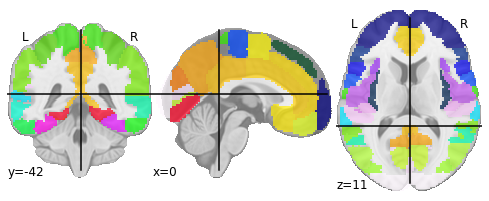

In [26]:
from nilearn import plotting
from nilearn import datasets
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_file = dataset.maps

# Visualize parcellation atlas
plotting.plot_roi(atlas_file);

In [27]:
masker = NiftiLabelsMasker(labels_img=atlas_file, standardize=True, verbose=1,
                           memory="nilearn_cache", memory_level=2)

[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {32, 40, 47, 48, 23, 24}. Label image only contains 43 labels (including background).
  warnings.warn("After resampling the label image to the "


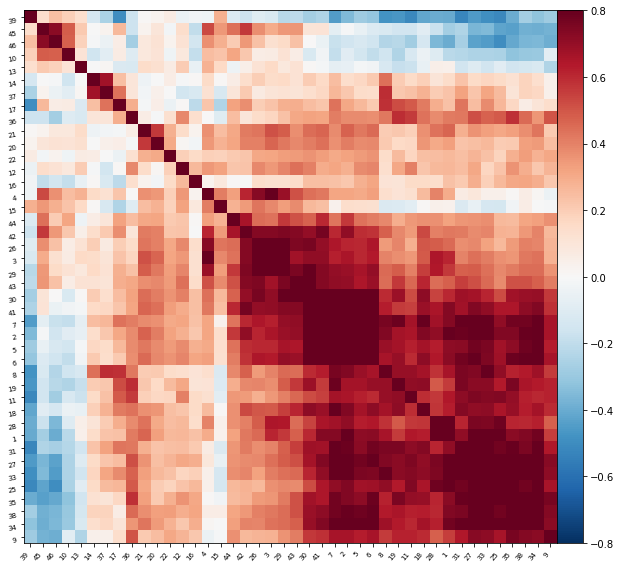

In [28]:
time_series = masker.fit_transform("E:/FYP-2023/Caltech/0051457/session_1/rest_1/rest.nii.gz")
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=masker.labels_,
                     vmax=0.8, vmin=-0.8, reorder=True, cmap='RdBu_r')

In [58]:
autism_features = []
for file in autism_image:
    print(file)
    time_series = masker.fit_transform(file)
    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    print(correlation_matrix.shape)
    flattened_matrix = correlation_matrix.flatten('C')
    print(flattened_matrix.shape)
    autism_features.append(flattened_matrix[:2000])

E:/FYP-2023/Caltech/0051456/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {40}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


(46, 46)
(2116,)
E:/FYP-2023/Caltech/0051459/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/Caltech/0051460/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {40}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


(46, 46)
(2116,)
E:/FYP-2023/Caltech/0051461/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(45, 45)
(2025,)

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {32}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "



E:/FYP-2023/Caltech/0051465/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/Caltech/0051466/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {40}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


(46, 46)
(2116,)
E:/FYP-2023/Caltech/0051467/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {32}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


(45, 45)
(2025,)
E:/FYP-2023/Caltech/0051471/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/Caltech/0051473/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(46, 46)
(2116,)
E:/FYP-2023/Caltech/0051474/session_1/rest_1/rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {40}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {18}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


(46, 46)
(2116,)
E:/FYP-2023/SDSU/0050182/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/SDSU/0050183/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/SDSU/0050184/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 37, 14}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


(45, 45)
(2025,)
E:/FYP-2023/Stanford/0051166/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Stanford/0051167/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Stanford/0051168/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampl

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


(46, 46)
(2116,)
E:/FYP-2023/Stanford/0051170/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(45, 45)


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {48}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


(2025,)
E:/FYP-2023/Stanford/0051171/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/Stanford/0051172/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(46, 46)


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {18, 26}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


(2116,)
E:/FYP-2023/Stanford/0051173/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Stanford/0051174/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Stanford/0051175/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling label

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


(46, 46)
(2116,)
E:/FYP-2023/Stanford/0051176/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Stanford/0051177/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {48, 37, 14}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


(45, 45)
(2025,)
E:/FYP-2023/Stanford/0051178/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Stanford/0051179/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


(46, 46)
(2116,)
E:/FYP-2023/OHSU/0050142/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/OHSU/0050143/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/OHSU/0050144/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


(46, 46)
(2116,)
E:/FYP-2023/SBL/0051572/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/SBL/0051573/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


(46, 46)
(2116,)
E:/FYP-2023/SBL/0051574/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/SBL/0051575/session_1/rest_1/rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {48}. Label image only contains 48 labels (including background).
  warnings.warn("After resampling the label image to the "


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


(46, 46)
(2116,)
E:/FYP-2023/SBL/0051576/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(46, 46)
(2116,)
E:/FYP-2023/SBL/0051577/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/SBL/0051578/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


(46, 46)
(2116,)
E:/FYP-2023/SBL/0051579/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/SBL/0051580/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/SBL/0051581/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {18}. Label image only contains 48 labels (including background).
  warnings.warn("After resampling the label image to the "


(47, 47)
(2209,)
E:/FYP-2023/SBL/0051582/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


(46, 46)
(2116,)
E:/FYP-2023/SBL/0051583/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(46, 46)
(2116,)
E:/FYP-2023/SBL/0051584/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {34}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


(45, 45)
(2025,)
E:/FYP-2023/SBL/0051585/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {38, 15}. Label image only contains 44 labels (including background).
  warnings.warn("After resampling the label image to the "


(43, 43)
(1849,)
E:/FYP-2023/Trinity/0050232/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Trinity/0050233/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Trinity/0050234/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {48, 37, 14}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


(45, 45)
(2025,)
E:/FYP-2023/Yale/0050605/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {34}. Label image only contains 45 labels (including background).
  warnings.warn("After resampling the label image to the "


(44, 44)
(1936,)
E:/FYP-2023/Yale/0050606/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {38, 15}. Label image only contains 43 labels (including background).
  warnings.warn("After resampling the label image to the "


(42, 42)
(1764,)
E:/FYP-2023/Yale/0050607/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Yale/0050608/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {32, 40, 47, 48, 22, 23, 24}. Label image only contains 42 labels (including background).
  warnings.warn("After resampling the label image to the "


(41, 41)
(1681,)
E:/FYP-2023/Yale/0050609/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Yale/0050610/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Yale/0050611/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 37, 14}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


(45, 45)
(2025,)
E:/FYP-2023/Yale/0050617/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {48}. Label image only contains 48 labels (including background).
  warnings.warn("After resampling the label image to the "


(47, 47)
(2209,)
E:/FYP-2023/Yale/0050618/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Yale/0050619/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Yale/0050620/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 37, 14}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


(45, 45)
(2025,)
E:/FYP-2023/Yale/0050621/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/Yale/0050622/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(46, 46)
(2116,)
E:/FYP-2023/Yale/0050623/session_1/rest_1/rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {14}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Yale/0050624/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Yale/0050625/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Yale/0050626/session_1/rest_1/rest.nii.gz
[

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 37, 38, 11, 14, 15}. Label image only contains 43 labels (including background).
  warnings.warn("After resampling the label image to the "


(42, 42)
(1764,)
E:/FYP-2023/Pitt/0050002/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(46, 46)
(2116,)
E:/FYP-2023/Pitt/0050003/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(45, 45)
(2025,)
E:/FYP-2023/Pitt/0050004/session_1/rest_1/rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {34}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Pitt/0050005/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Pitt/0050006/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Pitt/0050007/session_1/rest_1/rest.nii.gz
[

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


(46, 46)
(2116,)
E:/FYP-2023/Pitt/0050008/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(46, 46)
(2116,)
E:/FYP-2023/Pitt/0050009/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(46, 46)
(2116,)
E:/FYP-2023/Pitt/0050010/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {33, 34, 35, 37, 38, 39, 8, 9, 40, 11, 12, 44, 14, 15, 16, 25, 27}. Label image only contains 32 labels (including background).
  warnings.warn("After resampling the label image to the "


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(44, 44)
(1936,)
E:/FYP-2023/Pitt/0050013/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(45, 45)
(2025,)
E:/FYP-2023/Pitt/0050014/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Pitt/0050015/session_1/rest_1/rest.nii.gz
[

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


(46, 46)
(2116,)
E:/FYP-2023/Pitt/0050016/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(46, 46)
(2116,)
E:/FYP-2023/Pitt/0050017/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(41, 41)
(1681,)
E:/FYP-2023/Pitt/0050019/session_1/rest_1/rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 38, 39, 11, 15}. Label image only contains 42 labels (including background).
  warnings.warn("After resampling the label image to the "


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(43, 43)
(1849,)
E:/FYP-2023/Pitt/0050020/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(44, 44)
(1936,)
E:/FYP-2023/Pitt/0050022/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Pitt/0050023/session_1/rest_1/rest.nii.gz
[

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


(46, 46)
(2116,)
E:/FYP-2023/Pitt/0050024/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Pitt/0050025/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Pitt/0050026/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 37, 38, 14, 15}. Label image only contains 44 labels (including background).
  warnings.warn("After resampling the label image to the "


(43, 43)
(1849,)
E:/FYP-2023/Pitt/0050027/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Pitt/0050028/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Pitt/0050029/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Pitt/0050055/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Pitt/0050056/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


(46, 46)
(2116,)
E:/FYP-2023/Pitt/0050057/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/USM/0050475/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {48}. Label image only contains 48 labels (including background).
  warnings.warn("After resampling the label image to the "


(47, 47)
(2209,)
E:/FYP-2023/USM/0050476/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/USM/0050477/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/USM/0050478/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47,

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {32}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


(46, 46)
(2116,)
E:/FYP-2023/USM/0050483/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/USM/0050484/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {32}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


(46, 46)
(2116,)
E:/FYP-2023/USM/0050485/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/USM/0050486/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(44, 44)
(1936,)
E:/FYP-2023/USM/0050487/session_1/rest_1/rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 37, 14}. Label image only contains 45 labels (including background).
  warnings.warn("After resampling the label image to the "


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/USM/0050488/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {32}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


(46, 46)
(2116,)
E:/FYP-2023/USM/0050489/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/USM/0050490/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/USM/0050491/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47,

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


(46, 46)
(2116,)
E:/FYP-2023/USM/0050494/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/USM/0050495/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/USM/0050496/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47,

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {48}. Label image only contains 48 labels (including background).
  warnings.warn("After resampling the label image to the "


(47, 47)
(2209,)
E:/FYP-2023/USM/0050502/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/USM/0050503/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/USM/0050504/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47,

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14, 15}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


(45, 45)
(2025,)
E:/FYP-2023/USM/0050508/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/USM/0050509/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {48}. Label image only contains 48 labels (including background).
  warnings.warn("After resampling the label image to the "


(47, 47)
(2209,)
E:/FYP-2023/USM/0050510/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


(45, 45)
(2025,)
E:/FYP-2023/USM/0050511/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(46, 46)
(2116,)
E:/FYP-2023/USM/0050512/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/USM/0050513/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {32, 48}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


(46, 46)
(2116,)
E:/FYP-2023/USM/0050514/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/USM/0050515/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/USM/0050516/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47,

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 37, 14, 15}. Label image only contains 44 labels (including background).
  warnings.warn("After resampling the label image to the "


(43, 43)
(1849,)
E:/FYP-2023/USM/0050520/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/USM/0050521/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/USM/0050522/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48,

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {48, 37, 14}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


(45, 45)
(2025,)
E:/FYP-2023/USM/0050525/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/USM/0050526/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/USM/0050527/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


(45, 45)
(2025,)
E:/FYP-2023/USM/0050528/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/USM/0050529/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


(45, 45)
(2025,)
E:/FYP-2023/USM/0050530/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 38, 39, 11, 15, 25}. Label image only contains 40 labels (including background).
  warnings.warn("After resampling the label image to the "


(39, 39)
(1521,)
E:/FYP-2023/USM/0050531/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/USM/0050532/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {48}. Label image only contains 48 labels (including background).
  warnings.warn("After resampling the label image to the "


(47, 47)
(2209,)
E:/FYP-2023/KKI/0050791/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050792/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050793/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48,

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {32, 18, 22}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


(45, 45)
(2025,)
E:/FYP-2023/UCLA_1/0051212/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/UCLA_1/0051213/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/UCLA_1/0051214/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling la

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {18}. Label image only contains 48 labels (including background).
  warnings.warn("After resampling the label image to the "


(47, 47)
(2209,)
E:/FYP-2023/UCLA_1/0051220/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/UCLA_1/0051221/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/UCLA_1/0051222/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling la

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37}. Label image only contains 48 labels (including background).
  warnings.warn("After resampling the label image to the "


(47, 47)
(2209,)
E:/FYP-2023/UCLA_1/0051225/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/UCLA_1/0051226/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/UCLA_1/0051227/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling la

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {32, 18}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


(46, 46)
(2116,)
E:/FYP-2023/UCLA_1/0051239/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/UCLA_1/0051240/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/UCLA_1/0051241/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling la

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {48}. Label image only contains 48 labels (including background).
  warnings.warn("After resampling the label image to the "


(47, 47)
(2209,)
E:/FYP-2023/UCLA_2/0051291/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.image.resampling.resample_img...
resample_img(<nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>, interpolation='nearest', target_shape=(64, 64, 34), target_affine=array([[-2.997260e+00,  0.000000e+00,  1.709105e-01,  9.282883e+01],
       [-4.619612e-02,  2.798402e+00, -1.440254e+00, -5.251915e+01],
       [ 1.195691e-01,  1.081178e+00,  3.727795e+00, -6.738306e+01],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]]))
_____________________________________________________resample_img - 0.0s, 0.0min
_____________________________

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B0310>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[711.081996, ...,  82.822785],
       ...,
       [716.095365, ...,  80.632911]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.3s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B08B0>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[684.064826, ...,  82.263158],
       ...,
       [738.425872, ...,  82.611842]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.5s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B0610>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[668.820794, ...,  25.358744],
       ...,
       [672.561511, ...,  26.347534]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.5s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B0160>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[750.778136, ...,  85.202222],
       ...,
       [755.407972, ...,  85.788889]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.5s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B06A0>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[738.045521, ...,  86.86755 ],
       ...,
       [719.391777, ...,  84.907285]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.5s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B0640>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[871.641813, ...,  58.462322],
       ...,
       [879.256725, ...,  60.391039]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B08E0>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[682.349691, ...,  47.223108],
       ...,
       [679.741111, ...,  48.792829]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B02B0>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[776.457821, ...,  59.52459 ],
       ...,
       [781.020797, ...,  60.299766]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B0430>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[915.880128, ...,  74.954298],
       ...,
       [912.763747, ...,  79.144723]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B0580>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[876.5057  , ...,  47.991168],
       ...,
       [836.285881, ...,  43.571148]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.5s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B0DC0>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[674.365278, ..., 100.949917],
       ...,
       [677.149723, ..., 103.330551]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.3s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {48}. Label image only contains 48 labels (including background).
  warnings.warn("After resampling the label image to the "
C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B08B0>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[844.553991, ...,  72.6     ],
       ...,
       [858.639378, ...,  91.8     ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B0B50>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[642.024992, ...,  44.464088],
       ...,
       [643.193843, ...,  44.922652]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.5s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B08B0>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[761.805891, ...,  69.163462],
       ...,
       [729.298085, ...,  68.8125  ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.5s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B0B20>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[861.366967, ...,  24.72381 ],
       ...,
       [868.39023 , ...,  25.147619]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/UCLA_2/0051306/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E25F9ACA0>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\UCLA_2\0051306\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B0C10>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[666.297825, ...,  92.490956],
       ...,
       [665.91478 , ...,  88.072351]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.5s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B0DC0>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[693.354124, ...,  75.501982],
       ...,
       [701.742058, ...,  77.264201]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B0C10>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[886.630416, ...,  40.082621],
       ...,
       [888.002326, ...,  40.390313]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B0340>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[511.105724, ...,  36.581315],
       ...,
       [508.028621, ...,  35.551038]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.5s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {48}. Label image only contains 48 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/UCLA_2/0051310/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E25F837F0>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\UCLA_2\0051310\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B0250>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[816.035891, ..., 577.666667],
       ...,
       [789.05836 , ..., 590.538462]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B0460>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[574.831404, ...,  64.054889],
       ...,
       [578.821312, ...,  65.038593]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.3s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B06D0>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[942.782444, ...,  46.614203],
       ...,
       [953.564013, ...,  48.402111]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B0970>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[822.409557, ...,  71.542169],
       ...,
       [820.836998, ...,  67.460843]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B0040>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[743.555912, ...,  71.456545],
       ...,
       [737.788613, ...,  71.735079]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.3s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B0970>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[751.847953, ...,  83.14346 ],
       ...,
       [745.165205, ...,  86.700422]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B0C10>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[900.745121, ..., 118.61352 ],
       ...,
       [911.762016, ..., 122.158163]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B0430>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[769.680491, ...,  63.255132],
       ...,
       [772.971671, ...,  66.142229]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.5s, 0.0min

In [64]:
control_features = []
for file in control_image:
    print(file)
    time_series = masker.fit_transform(file)
    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    print(correlation_matrix.shape)
    flattened_matrix = correlation_matrix.flatten('C')
    print(flattened_matrix.shape)
    control_features.append(flattened_matrix[:2000])

E:/FYP-2023/Caltech/0051476/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(45, 45)
(2025,)
E:/FYP-2023/Caltech/0051477/session_1/rest_1/rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {32, 40, 48}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/Caltech/0051478/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/Caltech/0051479/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/Caltech/0051480/session_1/rest_1/rest

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {32, 40}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


(45, 45)
(2025,)
E:/FYP-2023/Caltech/0051481/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/Caltech/0051483/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(46, 46)
(2116,)
E:/FYP-2023/Caltech/0051484/session_1/rest_1/rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {40}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/Caltech/0051485/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {32, 40}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


(45, 45)
(2025,)
E:/FYP-2023/Caltech/0051486/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(46, 46)
(2116,)
E:/FYP-2023/Caltech/0051488/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(46, 46)
(2116,)
E:/FYP-2023/Caltech/0051489/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {32}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


(45, 45)
(2025,)
E:/FYP-2023/Caltech/0051493/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(45, 45)
(2025,)
E:/FYP-2023/SDSU/0050193/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/SDSU/0050194/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling label

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37}. Label image only contains 48 labels (including background).
  warnings.warn("After resampling the label image to the "


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/SDSU/0050204/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/SDSU/0050205/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/SDSU/0050206/session_1/rest_1/rest.nii.gz
[

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


(46, 46)
(2116,)
E:/FYP-2023/Stanford/0051189/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(46, 46)
(2116,)
E:/FYP-2023/Stanford/0051190/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(47, 47)
(2209,)
E:/FYP-2023/Stanford/0051192/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampl

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


(46, 46)
(2116,)
E:/FYP-2023/Stanford/0051196/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Stanford/0051197/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/Stanford/0051199/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampl

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


(46, 46)
(2116,)
E:/FYP-2023/OHSU/0050157/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/OHSU/0050158/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/OHSU/0050159/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37}. Label image only contains 48 labels (including background).
  warnings.warn("After resampling the label image to the "


(47, 47)
(2209,)
E:/FYP-2023/OHSU/0050163/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/OHSU/0050164/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(48, 48)
(2304,)
E:/FYP-2023/OHSU/0050166/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
_

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6910>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[255.169779, ...,  78.2607  ],
       ...,
       [257.564915, ...,  75.658885]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.1s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6C10>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[444.564972, ..., 107.157289],
       ...,
       [448.524989, ..., 104.38491 ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.3s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6370>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[507.396031, ...,  39.414634],
       ...,
       [501.755393, ...,  39.818999]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.1s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6220>)
____________________________________nifti_labels_masker_extractor - 0.5s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[606.945367, ...,  48.812652],
       ...,
       [613.438811, ...,  47.6691  ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.1s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6460>)
____________________________________nifti_labels_masker_extractor - 0.5s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[589.581779, ...,  44.152672],
       ...,
       [599.392191, ...,  43.854962]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.1s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6C40>)
____________________________________nifti_labels_masker_extractor - 0.5s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[456.585323, ..., 101.55202 ],
       ...,
       [457.719931, ..., 101.004896]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.1s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6E20>)
____________________________________nifti_labels_masker_extractor - 1.3s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[179.349724, ...,   0.359029],
       ...,
       [179.377532, ...,   0.346357]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.9s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6BE0>)
____________________________________nifti_labels_masker_extractor - 1.4s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[215.150504, ...,   1.619048],
       ...,
       [214.783685, ...,   1.47619 ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.2s, 0.1min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {33, 34, 35, 37, 38, 39, 8, 9, 11, 14, 15, 25, 27}. Label image only contains 36 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/SBL/0051558/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E25264E50>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\SBL\0051558\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6220>)
____________________________________nifti_labels_masker_extractor - 1.3s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[184.183857, ...,   2.13198 ],
       ...,
       [189.31435 , ...,   1.996616]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.8s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B64C0>)
____________________________________nifti_labels_masker_extractor - 1.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[224.587479, ...,   0.868421],
       ...,
       [226.460621, ...,   0.657895]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.3s, 0.1min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 37, 14, 15}. Label image only contains 45 labels (including background).
  warnings.warn("After resampling the label image to the "
C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B66A0>)
____________________________________nifti_labels_masker_extractor - 1.3s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[150.957069, ...,   0.823402],
       ...,
       [151.733284, ...,   0.853738]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.9s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6CD0>)
____________________________________nifti_labels_masker_extractor - 1.4s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[170.104857, ...,   2.959267],
       ...,
       [171.164643, ...,   3.08554 ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.2s, 0.1min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 37, 14}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/SBL/0051562/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E24E24D00>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\SBL\0051562\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B67C0>)
____________________________________nifti_labels_masker_extractor - 1.5s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[146.243887, ...,   0.486279],
       ...,
       [148.160661, ...,   0.526345]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.1s, 0.1min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B69A0>)
____________________________________nifti_labels_masker_extractor - 1.4s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[147.993039, ...,   3.444444],
       ...,
       [150.697014, ...,   3.472222]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.1s, 0.1min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6F70>)
____________________________________nifti_labels_masker_extractor - 1.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[217.066132, ...,   1.664474],
       ...,
       [217.430862, ...,   1.652961]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.3s, 0.1min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/SBL/0051565/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E24F282B0>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\SBL\0051565\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6D00>)
____________________________________nifti_labels_masker_extractor - 1.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[186.360793, ...,   0.581222],
       ...,
       [186.814264, ...,   0.608048]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.4s, 0.1min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {25, 34, 15}. Label image only contains 44 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/SBL/0051566/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E262B0820>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\SBL\0051566\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6C10>)
____________________________________nifti_labels_masker_extractor - 1.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[147.534131, ...,   1.974922],
       ...,
       [147.847974, ...,   1.948798]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.2s, 0.1min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6370>)
____________________________________nifti_labels_masker_extractor - 1.5s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[195.048015, ...,   5.869565],
       ...,
       [198.195432, ...,   6.043478]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.4s, 0.1min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6D00>)
____________________________________nifti_labels_masker_extractor - 1.5s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[119.569283, ...,   0.555556],
       ...,
       [120.53849 , ...,   0.584541]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.1s, 0.1min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 35, 38, 39, 40, 15, 16}. Label image only contains 40 labels (including background).
  warnings.warn("After resampling the label image to the "


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6AF0>)
____________________________________nifti_labels_masker_extractor - 1.5s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[153.81354 , ...,   1.726287],
       ...,
       [152.916441, ...,   1.753388]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.3s, 0.1min
(39, 39)
(1521,)
E:/FYP-2023/SBL/0051570/session_1/rest_1/rest.nii.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6A30>)
____________________________________nifti_labels_masker_extractor - 1.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[174.517254, ...,   0.955446],
       ...,
       [174.827079, ...,   0.956271]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.2s, 0.1min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6D90>)
____________________________________nifti_labels_masker_extractor - 1.3s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[440049.75, ..., 415228.1 ],
       ...,
       [425617.84, ..., 414453.34]], dtype=float32), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.4s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/Trinity/0050259/session_1/r

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B65E0>)
____________________________________nifti_labels_masker_extractor - 1.3s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[464614.2 , ..., 705618.  ],
       ...,
       [447719.03, ..., 700412.  ]], dtype=float32), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.3s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/Trinity/0050260/session_1/r

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6370>)
____________________________________nifti_labels_masker_extractor - 1.4s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[556619.94, ..., 562260.6 ],
       ...,
       [553906.56, ..., 563848.56]], dtype=float32), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.4s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/Trinity/0050261/session_1/r

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6940>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[439011.56 , ..., 116716.414],
       ...,
       [439163.56 , ..., 121814.37 ]], dtype=float32), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.3s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/Trinity/0050262/session

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6BE0>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[585494. , ..., 861546.7],
       ...,
       [603682.6, ..., 877545.2]], dtype=float32), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.2s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/Trinity/0050263/session_1/rest_

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B60D0>)
____________________________________nifti_labels_masker_extractor - 1.3s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[649751.75, ..., 561237.7 ],
       ...,
       [643912.6 , ..., 575980.75]], dtype=float32), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.3s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/Trinity/0050264/session_1/r

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6F70>)
____________________________________nifti_labels_masker_extractor - 1.1s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[627402.5 , ..., 557696.4 ],
       ...,
       [610277.75, ..., 563912.56]], dtype=float32), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.1s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/Trinity/0050265/session_1/r

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6100>)
____________________________________nifti_labels_masker_extractor - 1.3s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[458037.8 , ..., 287363.12],
       ...,
       [496511.7 , ..., 272546.9 ]], dtype=float32), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.2s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/Trinity/0050266/session_1/r

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6220>)
____________________________________nifti_labels_masker_extractor - 1.1s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[412485.88, ..., 473423.6 ],
       ...,
       [393744.97, ..., 483486.97]], dtype=float32), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.0s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/Trinity/0050267/session_1/r

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6E20>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[653311.3 , ..., 469391.5 ],
       ...,
       [641908.8 , ..., 478320.94]], dtype=float32), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.3s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/Trinity/0050268/session_1/r

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6490>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[595952.94, ..., 527578.2 ],
       ...,
       [586702.8 , ..., 539606.  ]], dtype=float32), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.3s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/Trinity/0050269/session_1/r

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6D00>)
____________________________________nifti_labels_masker_extractor - 1.3s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[541835.25, ..., 411292.06],
       ...,
       [534765.06, ..., 410570.53]], dtype=float32), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.3s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/Trinity/0050270/session_1/r

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6A30>)
____________________________________nifti_labels_masker_extractor - 1.4s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[465030.88, ..., 731119.4 ],
       ...,
       [449773.44, ..., 723049.1 ]], dtype=float32), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.5s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/Trinity/0050271/session_1/r

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B62E0>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[563323.25, ..., 853243.06],
       ...,
       [553042.7 , ..., 857025.25]], dtype=float32), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.1s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/Trinity/0051132/session_1/r

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6100>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[557477.06, ..., 529248.06],
       ...,
       [553612.25, ..., 547105.8 ]], dtype=float32), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.4s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/Trinity/0051133/session_1/r

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B65E0>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[724049.9, ..., 639579. ],
       ...,
       [754208.1, ..., 643050. ]], dtype=float32), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.2s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/Trinity/0051134/session_1/rest_

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6FD0>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[496979.53, ..., 374902.03],
       ...,
       [475175.06, ..., 368775.28]], dtype=float32), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.1s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/Trinity/0051135/session_1/r

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B66A0>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[664045.1 , ..., 150751.38],
       ...,
       [653556.44, ..., 165612.83]], dtype=float32), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.1s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/Trinity/0051136/session_1/r

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6BE0>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[549805.3 , ..., 168370.05],
       ...,
       [573621.8 , ..., 187737.8 ]], dtype=float32), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.1s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/Trinity/0051137/session_1/r

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6F70>)
____________________________________nifti_labels_masker_extractor - 1.1s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[611698.4 , ..., 420796.4 ],
       ...,
       [637880.9 , ..., 427994.97]], dtype=float32), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.0s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/Trinity/0051138/session_1/r

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6940>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[716226.25, ..., 436043.28],
       ...,
       [703552.25, ..., 441205.9 ]], dtype=float32), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.1s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/Trinity/0051139/session_1/r

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6AF0>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[552576.8 , ..., 390315.38],
       ...,
       [542724.94, ..., 402238.62]], dtype=float32), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.3s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/Trinity/0051140/session_1/r

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6460>)
____________________________________nifti_labels_masker_extractor - 1.3s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[749797.8 , ..., 834085.44],
       ...,
       [743490.2 , ..., 845332.75]], dtype=float32), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.3s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/Trinity/0051141/session_1/r

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6CD0>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[603114.75, ..., 676199.6 ],
       ...,
       [596788.25, ..., 693672.1 ]], dtype=float32), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.2s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/Trinity/0051142/session_1/r

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6A30>)
____________________________________nifti_labels_masker_extractor - 1.1s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[647649.56, ..., 832687.4 ],
       ...,
       [677476.56, ..., 832119.06]], dtype=float32), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.0s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/Yale/0050551/session_1/rest

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/Yale/0050551/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E0C0FC220>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\Yale\0050551\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6700>)
____________________________________nifti_labels_masker_extractor - 0.9s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[488.039588, ..., 138.835294],
       ...,
       [374.664687, ..., 113.981699]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.1s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B60D0>)
____________________________________nifti_labels_masker_extractor - 0.8s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[751.813055, ..., 383.544118],
       ...,
       [580.691773, ..., 304.080317]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.0s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {48, 37, 14}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/Yale/0050553/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E262B0820>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\Yale\0050553\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B68E0>)
____________________________________nifti_labels_masker_extractor - 0.8s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[687.381098, ...,  65.95    ],
       ...,
       [483.611662, ...,  46.7     ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.0s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6D90>)
____________________________________nifti_labels_masker_extractor - 0.8s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[538.535057, ..., 442.526316],
       ...,
       [378.575793, ..., 365.578947]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.1s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6730>)
____________________________________nifti_labels_masker_extractor - 0.8s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[1169.075206, ...,  244.488623],
       ...,
       [ 920.116725, ...,  191.653892]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.1s, 0.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6CA0>)
____________________________________nifti_labels_masker_extractor - 1.0s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[1124.171078, ...,   90.679389],
       ...,
       [ 868.274645, ...,   73.874591]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.1s, 0.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {48, 34, 37, 14}. Label image only contains 45 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/Yale/0050557/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E25F7E1F0>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\Yale\0050557\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6460>)
____________________________________nifti_labels_masker_extractor - 0.9s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[425.191129, ..., 125.352941],
       ...,
       [283.213306, ..., 115.470588]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.1s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {33, 35, 38, 39, 8, 9, 40, 11, 12, 15, 16, 25, 27}. Label image only contains 32 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/Yale/0050558/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E0AC08610>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\Yale\0050558\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6FD0>)
____________________________________nifti_labels_masker_extractor - 0.9s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[275.982237, ...,  25.565217],
       ...,
       [181.825658, ...,  15.652174]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.1s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B64C0>)
____________________________________nifti_labels_masker_extractor - 1.0s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[522.779729, ...,  40.021352],
       ...,
       [412.317239, ...,  33.374852]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.1s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6CD0>)
____________________________________nifti_labels_masker_extractor - 1.0s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[735.995038, ...,  42.972521],
       ...,
       [576.072137, ...,  35.847073]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.1s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {32, 34, 37, 38, 39, 11, 14, 15, 48, 25}. Label image only contains 39 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/Yale/0050561/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E2C2A6EE0>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\Yale\0050561\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6940>)
____________________________________nifti_labels_masker_extractor - 0.9s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[409.992939, ...,  31.636364],
       ...,
       [290.778924, ...,  24.454545]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.2s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6A30>)
____________________________________nifti_labels_masker_extractor - 0.9s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[445.849722, ...,  41.842857],
       ...,
       [321.784787, ...,  24.328571]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.3s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B66A0>)
____________________________________nifti_labels_masker_extractor - 1.0s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[ 42.376643, ..., 633.03556 ],
       ...,
       [ 35.260634, ..., 491.366379]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.2s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6910>)
____________________________________nifti_labels_masker_extractor - 0.8s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[752.834373, ...,  35.      ],
       ...,
       [579.749805, ...,  23.      ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.1s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/Yale/0050565/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E24F282B0>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\Yale\0050565\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6D00>)
____________________________________nifti_labels_masker_extractor - 1.0s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[591.41145 , ...,  57.587578],
       ...,
       [463.158397, ...,  45.404969]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.1s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B63D0>)
____________________________________nifti_labels_masker_extractor - 0.9s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[104.185633, ..., 949.477376],
       ...,
       [ 83.419282, ..., 751.164027]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.0s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6C40>)
____________________________________nifti_labels_masker_extractor - 0.9s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[1176.269008, ...,   19.      ],
       ...,
       [ 938.011193, ...,   19.      ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.2s, 0.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 37, 14}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/Yale/0050568/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E24F282B0>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\Yale\0050568\session_1\rest_1\rest.nii.gz
[NiftiLabelsM

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6910>)
____________________________________nifti_labels_masker_extractor - 1.0s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[619.978236, ..., 225.280311],
       ...,
       [484.980145, ..., 174.717464]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.1s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {48}. Label image only contains 48 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/Yale/0050570/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E252B8D30>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\Yale\0050570\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6BE0>)
____________________________________nifti_labels_masker_extractor - 1.0s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[987.879344, ...,  77.657895],
       ...,
       [786.910191, ...,  72.447368]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.3s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B62E0>)
____________________________________nifti_labels_masker_extractor - 1.0s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[841.369676, ...,  56.75    ],
       ...,
       [654.038687, ...,  45.85    ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.1s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6430>)
____________________________________nifti_labels_masker_extractor - 1.0s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[1258.923225, ...,  106.192982],
       ...,
       [ 961.615741, ...,   88.033918]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.1s, 0.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B68E0>)
____________________________________nifti_labels_masker_extractor - 0.8s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[860.198236, ..., 502.5087  ],
       ...,
       [661.711656, ..., 397.876151]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.0s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {48}. Label image only contains 48 labels (including background).
  warnings.warn("After resampling the label image to the "
C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6CD0>)
____________________________________nifti_labels_masker_extractor - 0.9s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[737.949981, ...,  60.5625  ],
       ...,
       [567.623885, ...,  48.40625 ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.1s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B69A0>)
____________________________________nifti_labels_masker_extractor - 1.0s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[1031.122226, ...,  290.54119 ],
       ...,
       [ 809.974803, ...,  218.671625]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.2s, 0.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {48}. Label image only contains 48 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/Yale/0050576/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E262B0820>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\Yale\0050576\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B65E0>)
____________________________________nifti_labels_masker_extractor - 0.8s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[1026.978846, ...,   33.135135],
       ...,
       [ 814.037692, ...,   29.432432]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.0s, 0.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6BE0>)
____________________________________nifti_labels_masker_extractor - 0.9s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[123.731575, ..., 801.075103],
       ...,
       [104.020559, ..., 627.695473]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.1s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6DC0>)
____________________________________nifti_labels_masker_extractor - 0.8s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
_______________________________________________filter_and_extract - 2.0s, 0.0min
(48, 48)
(2304,)
E:/FYP-2023/Pitt/0050030/session_1/rest_1/rest.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.image.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6490>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[409.882241, ...,  59.603878],
       ...,
       [403.964546, ...,  60.022161]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.9s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B69A0>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[386.772756, ..., 268.09901 ],
       ...,
       [383.544239, ..., 299.911881]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.8s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 37, 14, 15}. Label image only contains 45 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/Pitt/0050032/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E25264E50>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\Pitt\0050032\session_1\rest_1\rest.nii.gz
[NiftiLabelsM

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6400>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[321.706585, ..., 195.28245 ],
       ...,
       [320.157198, ..., 186.609689]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.8s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6BE0>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[406.337646, ...,  79.777676],
       ...,
       [399.20385 , ...,  78.569076]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.7s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {33, 34, 35, 37, 38, 39, 8, 9, 40, 11, 12, 44, 14, 15, 16, 25, 27}. Label image only contains 32 labels (including background).
  warnings.warn("After resampling the label image to the "
C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6CD0>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[236.627564, ..., 382.164122],
       ...,
       [233.251282, ..., 399.072519]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.7s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B67C0>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[434.125974, ...,  66.132143],
       ...,
       [430.002183, ...,  66.280357]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.8s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 37, 38, 14, 15}. Label image only contains 44 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/Pitt/0050037/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E25F70EB0>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\Pitt\0050037\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6CD0>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[330.29214 , ..., 141.142857],
       ...,
       [330.118537, ..., 159.228571]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.8s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6370>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[361.693716, ...,  67.415507],
       ...,
       [355.852858, ...,  67.369781]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.7s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6700>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[402.859058, ...,  34.83657 ],
       ...,
       [398.842532, ...,  34.386731]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.7s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6280>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[362.758249, ..., 215.483294],
       ...,
       [358.574239, ..., 219.937947]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.7s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6100>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[461.437169, ..., 235.869231],
       ...,
       [457.724353, ..., 231.302198]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.8s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6C40>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[316.289058, ..., 240.775319],
       ...,
       [315.020873, ..., 239.16766 ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.8s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6940>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[414.637436, ..., 114.103556],
       ...,
       [407.12213 , ..., 114.350418]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.7s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/Pitt/0050045/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E2C2A6FA0>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\Pitt\0050045\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6E20>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[449.298593, ..., 287.410861],
       ...,
       [449.554028, ..., 284.370902]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.7s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B65E0>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[234.22129 , ..., 107.526222],
       ...,
       [210.567097, ..., 110.728889]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.9s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {34}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "
C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6370>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[324.513746, ..., 165.240157],
       ...,
       [312.064922, ..., 166.799213]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.8s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6C40>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[377.910277, ..., 140.877551],
       ...,
       [357.602284, ..., 146.233236]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.8s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6280>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[328.130818, ..., 124.78673 ],
       ...,
       [323.532704, ..., 129.058768]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.9s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 37, 14, 15}. Label image only contains 45 labels (including background).
  warnings.warn("After resampling the label image to the "
C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6BE0>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[358.495825, ..., 368.830558],
       ...,
       [361.722863, ..., 384.475024]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.6s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6700>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[527.135714, ..., 169.298395],
       ...,
       [512.686039, ..., 170.919736]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.8s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6BE0>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[480.408163, ...,  34.859722],
       ...,
       [470.978336, ...,  36.019444]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.8s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B60D0>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[441.623305, ..., 202.758684],
       ...,
       [441.557456, ..., 202.648995]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.7s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {33, 34, 35, 37, 38, 39, 8, 9, 40, 11, 12, 44, 14, 15, 16, 25, 27}. Label image only contains 32 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/Pitt/0050058/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E2C178BE0>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\Pitt\0050058\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6CD0>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[376.932377, ..., 216.348315],
       ...,
       [361.103825, ..., 213.116854]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.8s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6BE0>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[408.832589, ..., 143.598326],
       ...,
       [419.95727 , ..., 162.82636 ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.7s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6DC0>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[366.777598, ..., 301.35629 ],
       ...,
       [362.55907 , ..., 305.535354]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.7s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {48}. Label image only contains 48 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/USM/0050432/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E252B8D30>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\USM\0050432\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6F70>)
____________________________________nifti_labels_masker_extractor - 1.1s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[699.935044, ..., 105.969697],
       ...,
       [694.038657, ..., 107.272727]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.8s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6910>)
____________________________________nifti_labels_masker_extractor - 1.1s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[719.304376, ...,  84.705882],
       ...,
       [723.556691, ...,  86.794118]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.8s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/USM/0050434/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E2C178BE0>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\USM\0050434\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B68E0>)
____________________________________nifti_labels_masker_extractor - 1.1s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[421.763642, ...,  56.8     ],
       ...,
       [430.326777, ...,  56.78    ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.9s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6E50>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[639.848543, ...,  61.777778],
       ...,
       [649.544989, ...,  62.055556]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.8s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/USM/0050436/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E0C0FC220>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\USM\0050436\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6100>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[490.560201, ...,  48.      ],
       ...,
       [492.951273, ...,  55.111111]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.0s, 0.1min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6FD0>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[637.817865, ..., 487.714286],
       ...,
       [644.791574, ..., 501.892857]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.9s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {32, 40}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/USM/0050438/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E2C178AF0>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\USM\0050438\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6400>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[645.964196, ...,  78.142857],
       ...,
       [649.145415, ...,  82.714286]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.0s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B63D0>)
____________________________________nifti_labels_masker_extractor - 1.3s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[689.653578, ...,  36.8     ],
       ...,
       [695.181127, ...,  32.8     ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.1s, 0.1min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 37, 14, 15, 48}. Label image only contains 44 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/USM/0050440/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E2C178AF0>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\USM\0050440\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6CD0>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[297.899139, ..., 115.777778],
       ...,
       [306.840508, ..., 144.388889]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.0s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6910>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[601.640331, ...,  60.825   ],
       ...,
       [587.748327, ...,  66.225   ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.0s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B60D0>)
____________________________________nifti_labels_masker_extractor - 1.1s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[734.391443, ...,  95.571429],
       ...,
       [727.686143, ...,  93.75    ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.8s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {32}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/USM/0050443/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E252A5D90>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\USM\0050443\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B60D0>)
____________________________________nifti_labels_masker_extractor - 1.1s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[638.840981, ..., 143.461538],
       ...,
       [630.52137 , ..., 132.230769]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.8s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6E50>)
____________________________________nifti_labels_masker_extractor - 1.3s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[673.191611, ...,  26.897959],
       ...,
       [672.358437, ...,  27.204082]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.0s, 0.1min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {32, 40, 37, 14}. Label image only contains 44 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/USM/0050445/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E24EC4460>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\USM\0050445\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B62E0>)
____________________________________nifti_labels_masker_extractor - 1.3s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[499.380096, ..., 146.714286],
       ...,
       [503.423435, ..., 130.571429]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.0s, 0.1min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6CA0>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[564.757346, ..., 165.125   ],
       ...,
       [564.192101, ..., 157.4375  ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.1s, 0.1min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 15}. Label image only contains 44 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/USM/0050447/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E25F70160>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\USM\0050447\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6D00>)
____________________________________nifti_labels_masker_extractor - 1.1s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[398.953432, ..., 111.233333],
       ...,
       [399.979303, ..., 121.      ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.7s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6370>)
____________________________________nifti_labels_masker_extractor - 1.1s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[792.750714, ...,  26.      ],
       ...,
       [796.817317, ...,  46.      ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.7s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {32, 48, 37, 14}. Label image only contains 45 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/USM/0050449/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E24ECB520>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\USM\0050449\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6CD0>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[481.20623 , ...,  50.4     ],
       ...,
       [474.583607, ...,  45.55    ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.9s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6730>)
____________________________________nifti_labels_masker_extractor - 1.1s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[506.110864, ..., 125.791667],
       ...,
       [505.065121, ..., 128.041667]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.9s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6A30>)
____________________________________nifti_labels_masker_extractor - 1.1s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[779.419395, ...,  58.16    ],
       ...,
       [784.045025, ...,  57.28    ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.0s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6C10>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[814.246445, ...,  48.852941],
       ...,
       [808.818325, ...,  49.529412]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.9s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6430>)
____________________________________nifti_labels_masker_extractor - 1.3s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[618.987568, ..., 276.153846],
       ...,
       [642.047816, ..., 304.384615]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.1s, 0.1min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6730>)
____________________________________nifti_labels_masker_extractor - 1.1s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[545.832179, ...,  89.      ],
       ...,
       [538.462217, ...,  92.05    ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.0s, 0.1min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B60D0>)
____________________________________nifti_labels_masker_extractor - 1.1s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[688.072072, ..., 148.155556],
       ...,
       [688.897173, ..., 150.6     ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.8s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6370>)
____________________________________nifti_labels_masker_extractor - 1.1s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[622.017926, ..., 164.380952],
       ...,
       [620.555698, ..., 161.238095]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.8s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6BE0>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[673.888043, ..., 114.090909],
       ...,
       [675.637488, ..., 114.      ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.9s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6730>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[771.826309, ...,  76.6     ],
       ...,
       [765.603768, ...,  74.9     ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.1s, 0.1min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/USM/0050460/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E25264640>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\USM\0050460\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6AF0>)
____________________________________nifti_labels_masker_extractor - 1.1s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[513.606745, ..., 125.0625  ],
       ...,
       [528.259943, ..., 142.21875 ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.9s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6910>)
____________________________________nifti_labels_masker_extractor - 1.1s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[544.033491, ...,  63.357143],
       ...,
       [538.407583, ...,  66.071429]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.9s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6A30>)
____________________________________nifti_labels_masker_extractor - 1.3s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[738.160486, ...,  64.977273],
       ...,
       [740.824169, ...,  68.25    ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.0s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6CD0>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[682.425518, ...,  77.944444],
       ...,
       [695.939713, ...,  75.333333]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.9s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6D00>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[759.244367, ...,  54.166667],
       ...,
       [783.679784, ...,  52.166667]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.1s, 0.1min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6220>)
____________________________________nifti_labels_masker_extractor - 1.3s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[792.756051, ...,  35.03125 ],
       ...,
       [793.099045, ...,  32.78125 ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.9s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6BE0>)
____________________________________nifti_labels_masker_extractor - 1.1s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[650.679734, ...,  31.113636],
       ...,
       [632.246917, ...,  43.181818]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.9s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6DC0>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[796.84474 , ...,  97.666667],
       ...,
       [780.475602, ..., 112.055556]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.0s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6460>)
____________________________________nifti_labels_masker_extractor - 1.1s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[743.884274, ...,  29.730829],
       ...,
       [740.435637, ...,  29.56025 ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.9s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6280>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[749.570394, ...,  33.285714],
       ...,
       [747.334803, ...,  32.      ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.0s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B67C0>)
____________________________________nifti_labels_masker_extractor - 1.1s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[685.506013, ...,  39.929825],
       ...,
       [684.764241, ...,  44.035088]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.7s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6F70>)
____________________________________nifti_labels_masker_extractor - 1.1s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[756.735406, ...,  19.5     ],
       ...,
       [754.21066 , ...,  19.      ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.9s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {48}. Label image only contains 48 labels (including background).
  warnings.warn("After resampling the label image to the "


________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('E:/FYP-2023/USM/0050472/session_1/rest_1/rest.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x0000014E2C178AF0>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x0000014E24EC44C0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from E:\FYP-2023\USM\0050472\session_1\rest_1\rest.nii.gz


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6910>)
____________________________________nifti_labels_masker_extractor - 1.1s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[640.527027, ..., 149.24    ],
       ...,
       [649.515122, ..., 155.68    ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.9s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6E50>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[792.264013, ..., 159.409091],
       ...,
       [793.4     , ..., 161.227273]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.0s, 0.1min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6280>)
____________________________________nifti_labels_masker_extractor - 1.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[595.004732, ..., 129.59375 ],
       ...,
       [602.258991, ..., 131.25    ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.9s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B67C0>)
____________________________________nifti_labels_masker_extractor - 1.8s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[891.817276, ...,  39.476376],
       ...,
       [881.64417 , ...,  43.79396 ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.5s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050773/session_1/rest_1/rest.nii.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6DC0>)
____________________________________nifti_labels_masker_extractor - 1.8s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[742.098685, ..., 609.52207 ],
       ...,
       [752.867835, ..., 559.20345 ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.5s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050774/session_1/rest_1/rest.nii.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B63D0>)
____________________________________nifti_labels_masker_extractor - 2.1s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[778.037438, ...,  19.253288],
       ...,
       [776.415078, ...,  22.222601]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.6s, 0.1min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6730>)
____________________________________nifti_labels_masker_extractor - 1.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[1043.152499, ...,   90.305407],
       ...,
       [1036.814357, ...,   83.429128]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.3s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050776/session_1/rest_1/rest.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B66A0>)
____________________________________nifti_labels_masker_extractor - 1.9s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[727.947965, ...,  26.2981  ],
       ...,
       [666.416967, ...,  33.099367]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.5s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050777/session_1/rest_1/rest.nii.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6BE0>)
____________________________________nifti_labels_masker_extractor - 1.9s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[765.627172, ...,  42.238571],
       ...,
       [766.364489, ...,  46.452969]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.5s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050778/session_1/rest_1/rest.nii.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6490>)
____________________________________nifti_labels_masker_extractor - 1.8s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[672.527046, ..., 138.103831],
       ...,
       [663.547586, ..., 126.652218]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.3s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050779/session_1/rest_1/rest.nii.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6730>)
____________________________________nifti_labels_masker_extractor - 1.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[308.766558, ...,  93.734818],
       ...,
       [371.345605, ...,  57.442308]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.3s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050780/session_1/rest_1/rest.nii.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6E20>)
____________________________________nifti_labels_masker_extractor - 1.8s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[598.227068, ..., 298.471611],
       ...,
       [605.187262, ..., 260.6711  ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.3s, 0.1min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6700>)
____________________________________nifti_labels_masker_extractor - 1.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[786.65904 , ..., 146.912487],
       ...,
       [838.768244, ..., 116.680143]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.6s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050782/session_1/rest_1/rest.nii.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B64C0>)
____________________________________nifti_labels_masker_extractor - 1.8s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[898.74034 , ...,  18.350706],
       ...,
       [894.254165, ...,  25.910862]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.4s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050783/session_1/rest_1/rest.nii.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6CD0>)
____________________________________nifti_labels_masker_extractor - 1.8s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[791.824489, ...,  24.534827],
       ...,
       [790.901769, ...,  35.115928]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.5s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050784/session_1/rest_1/rest.nii.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6E50>)
____________________________________nifti_labels_masker_extractor - 2.2s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[540.879262, ...,  25.412875],
       ...,
       [597.569937, ...,  31.237173]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.7s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050785/session_1/rest_1/rest.nii.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6E50>)
____________________________________nifti_labels_masker_extractor - 1.9s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[927.19818 , ...,  17.715538],
       ...,
       [941.662545, ...,  20.269849]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.6s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050786/session_1/rest_1/rest.nii.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6490>)
____________________________________nifti_labels_masker_extractor - 1.9s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[860.234415, ...,  24.404774],
       ...,
       [859.386914, ...,  27.997077]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.5s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050787/session_1/rest_1/rest.nii.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B66A0>)
____________________________________nifti_labels_masker_extractor - 2.0s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[843.241285, ...,  14.498782],
       ...,
       [860.517603, ...,  16.652216]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.7s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050788/session_1/rest_1/rest.nii.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6280>)
____________________________________nifti_labels_masker_extractor - 2.0s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[839.910184, ...,  22.533853],
       ...,
       [849.920488, ...,  27.461763]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.6s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050789/session_1/rest_1/rest.nii.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B67C0>)
____________________________________nifti_labels_masker_extractor - 1.9s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[933.818994, ...,  23.046761],
       ...,
       [890.56792 , ...,  26.584023]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.5s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050790/session_1/rest_1/rest.nii.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6280>)
____________________________________nifti_labels_masker_extractor - 1.9s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[771.947965, ...,  32.920117],
       ...,
       [788.60656 , ...,  42.72187 ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.5s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050808/session_1/rest_1/rest.nii.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6280>)
____________________________________nifti_labels_masker_extractor - 2.1s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[353.1256, ..., 731.2054],
       ...,
       [395.41  , ..., 719.1137]], dtype=float32), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.2s, 0.0min
_______________________________________________filter_and_extract - 6.5s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050809/session_1/rest_1/re

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6C10>)
____________________________________nifti_labels_masker_extractor - 1.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[902.660298, ..., 165.869613],
       ...,
       [927.320245, ..., 137.036552]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.3s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050810/session_1/rest_1/rest.nii.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B69A0>)
____________________________________nifti_labels_masker_extractor - 1.8s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[856.777434, ...,  40.964442],
       ...,
       [813.832732, ...,  35.814418]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.4s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050811/session_1/rest_1/rest.nii.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6C10>)
____________________________________nifti_labels_masker_extractor - 1.8s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[824.774352, ..., 346.032055],
       ...,
       [844.311493, ..., 311.753022]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.5s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050812/session_1/rest_1/rest.nii.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6460>)
____________________________________nifti_labels_masker_extractor - 1.8s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[568.943803, ..., 272.580662],
       ...,
       [557.717437, ..., 209.04309 ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.2s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050813/session_1/rest_1/rest.nii.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B63D0>)
____________________________________nifti_labels_masker_extractor - 1.9s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[779.57977 , ...,  15.759377],
       ...,
       [774.114889, ...,  19.245981]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.4s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050814/session_1/rest_1/rest.nii.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B66A0>)
____________________________________nifti_labels_masker_extractor - 1.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[1018.284694, ...,  794.568205],
       ...,
       [1036.605781, ...,  781.03661 ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.3s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050816/session_1/rest_1/rest.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6430>)
____________________________________nifti_labels_masker_extractor - 1.5s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[498.939061, ...,  90.63182 ],
       ...,
       [540.905757, ...,  78.871494]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.7s, 0.1min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B63D0>)
____________________________________nifti_labels_masker_extractor - 1.5s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[516.477555, ...,  73.170321],
       ...,
       [553.543057, ...,  66.677206]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 3.7s, 0.1min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B68E0>)
____________________________________nifti_labels_masker_extractor - 1.9s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[527.528843, ..., 155.616764],
       ...,
       [551.228497, ..., 142.11531 ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.5s, 0.1min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6AF0>)
____________________________________nifti_labels_masker_extractor - 1.8s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[855.274356, ..., 137.30229 ],
       ...,
       [809.546277, ..., 128.474809]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.6s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050820/session_1/rest_1/rest.nii.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6280>)
____________________________________nifti_labels_masker_extractor - 1.8s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[766.476043, ...,  47.047248],
       ...,
       [778.017173, ...,  51.492937]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.5s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050821/session_1/rest_1/rest.nii.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6100>)
____________________________________nifti_labels_masker_extractor - 2.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[700.013099, ...,  18.20653 ],
       ...,
       [684.821923, ...,  19.848544]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 6.1s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/KKI/0050822/session_1/rest_1/rest.nii.

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6C10>)
____________________________________nifti_labels_masker_extractor - 1.8s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[499.534993, ..., 101.298006],
       ...,
       [540.391713, ...,  91.992655]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 4.5s, 0.1min
(48, 48)
(2304,)
E:/FYP-2023/UCLA_1/0051250/session_1/rest_1/rest.n

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6CA0>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[830.395281, ...,  64.821145],
       ...,
       [835.216429, ...,  65.007048]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.5s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6C40>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[664.453533, ...,  28.803604],
       ...,
       [651.85752 , ...,  27.956757]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B64C0>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[826.596906, ...,  56.554237],
       ...,
       [828.055458, ...,  57.785593]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.3s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6100>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[897.542067, ...,  24.017621],
       ...,
       [896.920815, ...,  23.449339]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.3s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B64C0>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[725.418092, ...,  39.557047],
       ...,
       [726.887171, ...,  40.52349 ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.5s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6940>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[573.810422, ...,  70.056459],
       ...,
       [568.596586, ...,  70.580838]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6100>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[705.946695, ...,  59.302993],
       ...,
       [721.496802, ...,  60.218204]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B60D0>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[797.573047, ...,  90.221098],
       ...,
       [816.789137, ...,  85.65896 ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6730>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[855.342933, ...,  33.781182],
       ...,
       [862.205407, ...,  32.875274]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6910>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[643.439175, ..., 116.527415],
       ...,
       [642.085925, ..., 116.146214]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.5s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B60D0>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[739.478501, ...,  33.072893],
       ...,
       [739.101104, ...,  34.364465]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6940>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[678.2684  , ..., 336.582069],
       ...,
       [687.534171, ..., 315.373793]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B69A0>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[742.594051, ...,  63.726345],
       ...,
       [758.538933, ...,  65.394249]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6280>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[816.961787, ...,  67.64991 ],
       ...,
       [809.42475 , ...,  68.115799]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6BE0>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[816.530012, ...,  97.726872],
       ...,
       [814.349942, ..., 100.655286]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6490>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[881.375981, ..., 104.045296],
       ...,
       [872.761559, ..., 103.536585]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.5s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6BE0>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[886.325234, ...,  58.129602],
       ...,
       [889.352459, ...,  58.583211]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.5s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B69A0>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[528.871811, ..., 128.32797 ],
       ...,
       [521.349921, ..., 128.450495]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B64C0>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[678.248126, ..., 130.61499 ],
       ...,
       [687.642271, ..., 137.73614 ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6D00>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[704.746508, ...,  31.154215],
       ...,
       [705.648137, ...,  32.8659  ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6F70>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[733.109016, ...,  32.427896],
       ...,
       [734.127283, ...,  32.      ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6C10>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[827.697791, ...,  38.932275],
       ...,
       [831.106627, ...,  40.063492]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6430>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[910.038878, ...,  27.689922],
       ...,
       [915.662672, ...,  28.510078]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6CA0>)
____________________________________nifti_labels_masker_extractor - 0.6s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[722.492393, ...,  48.787215],
       ...,
       [717.119661, ...,  49.287215]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.5s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6370>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[722.722874, ...,  37.532995],
       ...,
       [723.025806, ...,  38.898477]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.5s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6FD0>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[953.140534, ...,  29.626866],
       ...,
       [952.462834, ...,  30.151741]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.5s, 0.0min

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\base_masker.py:112: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  region_signals, aux = cache(extraction_function, memory,


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x0000014E2C2B6460>)
____________________________________nifti_labels_masker_extractor - 0.7s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[825.106674, ...,  40.773535],
       ...,
       [822.687263, ...,  41.50444 ]]), detrend=False, standardize=True, standardize_confounds=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.4s, 0.0min

In [65]:
features  = autism_features+control_features

In [66]:
df_features = pd.DataFrame(features)
#df_features.to_csv("E:/FYP-2023/function_connectivity_features.csv",index  = None)

In [67]:
autism_info = pd.read_csv("E:/FYP-2023/autism_info.csv")
control_info = pd.read_csv("E:/FYP-2023/control_info.csv")
concat_info = pd.concat([autism_info,control_info],axis = 0,ignore_index = True)

In [68]:
df_features  = pd.read_csv("E:/FYP-2023/function_connectivity_features.csv")
df_data = pd.concat([df_features,concat_info["DX_GROUP"]],axis = 1)
df_data["DX_GROUP"] = df_data["DX_GROUP"].replace([1,2], [0,1])

In [69]:
#df_data.to_csv("E:/FYP-2023/features_df.csv",index = None)

In [70]:
df_features = pd.read_csv("E:/FYP-2023/features_df.csv")

In [36]:
import zipfile

In [12]:
!unzip -v

UnZip 6.00 of 20 April 2009, by Info-ZIP.  Maintained by C. Spieler.  Send
bug reports using http://www.info-zip.org/zip-bug.html; see README for details.

Latest sources and executables are at ftp://ftp.info-zip.org/pub/infozip/ ;
see ftp://ftp.info-zip.org/pub/infozip/UnZip.html for other sites.

Compiled with Microsoft C 13.10 (Visual C++ 7.1) for 
Windows 9x / Windows NT/2K/XP/2K3 (32-bit) on Apr 20 2009.

UnZip special compilation options:
        ASM_CRC
        COPYRIGHT_CLEAN (PKZIP 0.9x unreducing method not supported)
        NTSD_EAS
        SET_DIR_ATTRIB
        TIMESTAMP
        UNIXBACKUP
        USE_EF_UT_TIME
        USE_UNSHRINK (PKZIP/Zip 1.x unshrinking method supported)
        USE_DEFLATE64 (PKZIP 4.x Deflate64(tm) supported)
        UNICODE_SUPPORT [wide-chars] (handle UTF-8 paths)
        MBCS-support (multibyte character support, MB_CUR_MAX = 1)
        LARGE_FILE_SUPPORT (large files over 2 GiB supported)
        ZIP64_SUPPORT (archives using Zip64 for large f

Cobat Harmonization for functional connectivity

In [71]:
!unzip neurocombat_sklearn -d .

^C


In [29]:
from neurocombat_sklearn import CombatModel

# Load the functional connectivity matrix data
df_features = pd.read_csv("E:/FYP-2023/features_df.csv")

# drop any rows with missing or NaN values
df_features.dropna(inplace=True)

# replace NaN, infinity, and large values with a specific value
#df_features = df_features.replace([np.nan, np.inf, -np.inf, np.finfo(float).max], 999)
# Define the features (functional connectivity) and labels (diagnosis)
X = df_features.iloc[:, 1:].values
y = df_features['DX_GROUP'].values.reshape(-1,1)


# Create a ComBat harmonization model
combat_model = CombatModel()

# Fit the model 
X = combat_model.fit_transform(X, y)
X

C:\Users\HP\neurocombat_sklearn\neurocombat_sklearn.py:258: RuntimeWarning: divide by zero encountered in true_divide
  standardized_data = ((data - standardized_mean) / np.dot(np.sqrt(self.var_pooled), np.ones((1, n_samples))))
C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\HP\neurocombat_sklearn\neurocombat_sklearn.py:258: RuntimeWarning: divide by zero encountered in true_divide
  standardized_data = ((data - standardized_mean) / np.dot(np.sqrt(self.var_pooled), np.ones((1, n_samples))))


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [96]:
#from neurocombat_sklearn import CombatModel

# Load the functional connectivity matrix data
#df_features = pd.read_csv("C:/Users/HP/Downloads/features_df.csv")

# drop any rows with missing or NaN values
#df_features.dropna(inplace=True)
# Define the features (functional connectivity) and labels (diagnosis)
#X = df_features.iloc[:, 1:].values
#y = df_features['DX_GROUP'].values.reshape(-1,1)


# Create a ComBat harmonization model
#combat_model = CombatModel()

# Fit the model 
#X = combat_model.fit_transform(X, y)
#X

C:\Users\HP\neurocombat_sklearn\neurocombat_sklearn.py:258: RuntimeWarning: divide by zero encountered in true_divide
  standardized_data = ((data - standardized_mean) / np.dot(np.sqrt(self.var_pooled), np.ones((1, n_samples))))
C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\HP\neurocombat_sklearn\neurocombat_sklearn.py:258: RuntimeWarning: divide by zero encountered in true_divide
  standardized_data = ((data - standardized_mean) / np.dot(np.sqrt(self.var_pooled), np.ones((1, n_samples))))


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [30]:
# # Separating features and output class
X = df_features.iloc[:,:-1]
y = df_features.iloc[:,-1]

In [31]:
len(X)
len(y)

585

In [32]:
# dataset split into training and testing
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [33]:
y_train_labels = to_categorical(y_train)
y_test_labels = to_categorical(y_test)

In [34]:
len(y_test_labels)

117

Training using Ann

In [35]:
# Initialising the ANN
ann_model = Sequential()
# Adding the input layer and the first hidden layer
ann_model.add(Dense(units =256, activation = 'relu', input_dim = X_train.shape[1]))
ann_model.add(BatchNormalization())
# Adding the second hidden layer
ann_model.add(Dense(128,activation = 'relu', kernel_initializer = 'uniform'))
ann_model.add(BatchNormalization())
ann_model.add(Dropout(0.1))
ann_model.add(Dense(64,activation = 'relu', kernel_initializer = 'uniform'))
ann_model.add(BatchNormalization())
ann_model.add(Dropout(0.3))
ann_model.add(Dense(32,activation = 'relu', kernel_initializer = 'uniform'))
ann_model.add(BatchNormalization())
ann_model.add(Dropout(0.5))
# Adding the output layer
ann_model.add(Dense(units = 2, activation = 'softmax'))
# Compiling the ANN
ann_model.compile(optimizer = Adam(0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
ann_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               512256    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8

In [8]:
# Model training
#checkpointer = ModelCheckpoint('E:/FYP-2023/ann_weight.h5', verbose=1, save_best_only=True, monitor='val_accuracy')
ann_model.fit(X_train, y_train_labels, validation_data=(X_test, y_test_labels), epochs = 500, batch_size = 16)
#ann_model.fit(X_train, y_train_labels, validation_data=(X_test, y_test_labels), epochs = 500, batch_size = 16,callbacks=[checkpointer])

Epoch 1/500
30/30 [==============================] - 2s 15ms/step - loss: 1.2032 - accuracy: 0.4765 - val_loss: 0.6909 - val_accuracy: 0.4957
Epoch 2/500
30/30 [==============================] - 0s 5ms/step - loss: 0.8808 - accuracy: 0.5556 - val_loss: 0.6899 - val_accuracy: 0.5299
Epoch 3/500
30/30 [==============================] - 0s 5ms/step - loss: 0.8789 - accuracy: 0.5278 - val_loss: 0.6945 - val_accuracy: 0.5214
Epoch 4/500
30/30 [==============================] - 0s 5ms/step - loss: 0.8200 - accuracy: 0.5577 - val_loss: 0.6932 - val_accuracy: 0.5299
Epoch 5/500
30/30 [==============================] - 0s 6ms/step - loss: 0.8466 - accuracy: 0.5534 - val_loss: 0.6832 - val_accuracy: 0.5556
Epoch 6/500
30/30 [==============================] - 0s 7ms/step - loss: 0.8058 - accuracy: 0.5748 - val_loss: 0.7012 - val_accuracy: 0.4701
Epoch 7/500
30/30 [==============================] - 0s 7ms/step - loss: 0.7590 - accuracy: 0.5705 - val_loss: 0.6913 - val_accuracy: 0.4872
Epoch 8/500


Validation

In [36]:
model_weight = load_model("E:/FYP-2023/ann_weight.h5")
prediction = model_weight.predict(X_test)

4/4 [==============================] - 1s 6ms/step


In [92]:
#model_weight=load_model("C:/Users/HP/Downloads/ann_weight(70%).h5")
#prediction = model_weight.predict(X_test)

4/4 [==============================] - 0s 3ms/step


In [161]:
#model_weight=load_model("C:/Users/HP/Downloads/model_weight.h5")
#prediction = model_weight.predict(X_test)

4/4 [==============================] - 0s 2ms/step


In [37]:
classNames = ['Autism', 'Control']
print(classification_report(y_test_labels.argmax(axis=1),
	prediction.argmax(axis=1), target_names=classNames))

              precision    recall  f1-score   support

      Autism       0.98      0.67      0.80        61
     Control       0.73      0.98      0.84        56

    accuracy                           0.82       117
   macro avg       0.85      0.83      0.82       117
weighted avg       0.86      0.82      0.82       117



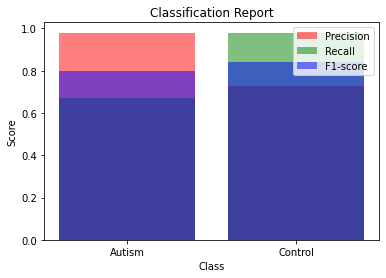

In [38]:
import matplotlib.pyplot as plt

precision = [0.98, 0.73]
recall = [0.67, 0.98]
f1_score = [0.80, 0.84]

x = ['Autism', 'Control']

plt.bar(x, precision, color='red', alpha=0.5, label='Precision')
plt.bar(x, recall, color='green', alpha=0.5, label='Recall')
plt.bar(x, f1_score, color='blue', alpha=0.5, label='F1-score')

plt.title('Classification Report')
plt.xlabel('Class')
plt.ylabel('Score')
plt.legend()
plt.show()

Epoch 1/10
15/15 [==============================] - 3s 57ms/step - loss: 0.5397 - accuracy: 0.8632 - val_loss: 0.6166 - val_accuracy: 0.8034
Epoch 2/10
15/15 [==============================] - 0s 14ms/step - loss: 0.3657 - accuracy: 0.8697 - val_loss: 0.5184 - val_accuracy: 0.8462
Epoch 3/10
15/15 [==============================] - 0s 12ms/step - loss: 0.3090 - accuracy: 0.8825 - val_loss: 0.4637 - val_accuracy: 0.8291
Epoch 4/10
15/15 [==============================] - 0s 12ms/step - loss: 0.3119 - accuracy: 0.8974 - val_loss: 0.4461 - val_accuracy: 0.8462
Epoch 5/10
15/15 [==============================] - 0s 12ms/step - loss: 0.2744 - accuracy: 0.8953 - val_loss: 0.4473 - val_accuracy: 0.8547
Epoch 6/10
15/15 [==============================] - 0s 12ms/step - loss: 0.2505 - accuracy: 0.8953 - val_loss: 0.4422 - val_accuracy: 0.8291
Epoch 7/10
15/15 [==============================] - 0s 13ms/step - loss: 0.2204 - accuracy: 0.9145 - val_loss: 0.4594 - val_accuracy: 0.8205
Epoch 8/10
15

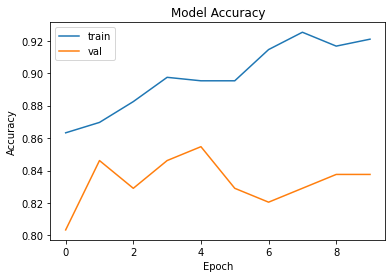

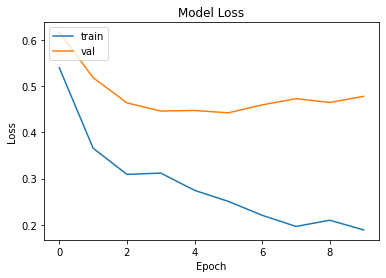

In [39]:
import matplotlib.pyplot as plt

# Train the model and obtain the history object
history = model_weight.fit(X_train, y_train_labels, validation_data=(X_test, y_test_labels), epochs=10, batch_size=32)

# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


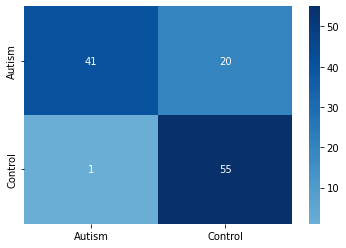

In [40]:
import seaborn as sns
CM = confusion_matrix(y_test_labels.argmax(axis=1),
	prediction.argmax(axis=1))
# drawing confusion matrix
sns.heatmap(CM, center = True , annot=True, fmt="d" ,cmap="Blues", xticklabels=classNames, yticklabels=classNames)
plt.show()

In [41]:
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
CM = confusion_matrix(y_test_labels.argmax(axis=1), prediction.argmax(axis=1))

# Calculate the true positives, true negatives, false positives, and false negatives
TP = CM[1,1]
TN = CM[0,0]
FP = CM[0,1]
FN = CM[1,0]

# Calculate the accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)
print("Accuracy for ANN:", accuracy*100)

Accuracy for ANN: 82.05128205128204


Training svm model

In [42]:
svm_model =  svm.LinearSVC(C=5)
svm_model.fit(X_train,y_train)
#pickle.dump(svm_model,open("C:/Users/HP/Downloads/svm_weight.p","wb"))
pickle.dump(svm_model,open("E:/FYP-2023/svm_weight.p","wb"))

C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation

In [43]:
predictions = svm_model.predict(X_test)
print('Accuracy of Svm model (Svm): {0:.2f}'.format(accuracy_score(y_test, predictions)*100))

Accuracy of Svm model (Svm): 47.86


In [44]:
#classification report
labels = ["Autism ","control"]
print("Classification Report: \n\n", classification_report(y_test, predictions,target_names = labels))

Classification Report: 

               precision    recall  f1-score   support

     Autism        0.50      0.52      0.51        61
     control       0.45      0.43      0.44        56

    accuracy                           0.48       117
   macro avg       0.48      0.48      0.48       117
weighted avg       0.48      0.48      0.48       117



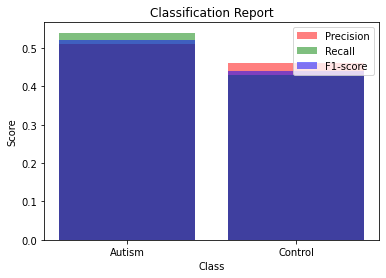

In [45]:
import matplotlib.pyplot as plt

precision = [0.51, 0.46]
recall = [0.54, 0.43]
f1_score = [0.52, 0.44]

x = ['Autism', 'Control']

plt.bar(x, precision, color='red', alpha=0.5, label='Precision')
plt.bar(x, recall, color='green', alpha=0.5, label='Recall')
plt.bar(x, f1_score, color='blue', alpha=0.5, label='F1-score')

plt.title('Classification Report')
plt.xlabel('Class')
plt.ylabel('Score')
plt.legend()
plt.show()

Confusion Matrix:


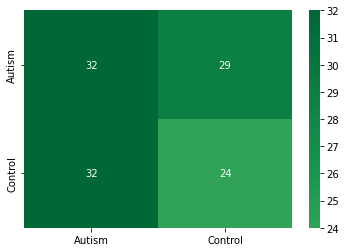

In [46]:
# Compute the error.
CM = confusion_matrix(y_test, predictions)
print('Confusion Matrix:')
labels = ["Autism","Control"]
# drawing confusion matrix
sns.heatmap(CM, center = True , annot=True, fmt="d" ,cmap="RdYlGn",xticklabels = labels,yticklabels=labels)
plt.show()
print()

In [ ]:
#TP = 10
#TN = 7
#FP = 4
#FN = 6

#N = TP + TN + FP + FN 

#accuracy = (TP + TN) / N 
#print("Accuracy for SVM:", accuracy*100)

Cnn model

In [47]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import Input, layers
from tensorflow.keras import backend as K
import tensorflow as tf
from keras.layers import Dense, Flatten, Convolution1D, Dropout

In [48]:
# convolution neural network training
model = Sequential()
model.add(Convolution1D(filters = 16, kernel_size = 3, input_shape=(X_train.shape[1],1)))
model.add(Convolution1D(filters = 32, kernel_size = 1, activation='relu'))
model.add(Convolution1D(filters = 64, kernel_size = 1, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1998, 16)          64        
                                                                 
 conv1d_1 (Conv1D)           (None, 1998, 32)          544       
                                                                 
 conv1d_2 (Conv1D)           (None, 1998, 64)          2112      
                                                                 
 batch_normalization_4 (Batc  (None, 1998, 64)         256       
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 127872)            0         
                                                                 
 dense_5 (Dense)             (None, 128)               16367744  
                                                      

In [53]:
# Model training
#checkpointer = ModelCheckpoint('E:/FYP-2023/cnn_weight.h5', verbose=1, save_best_only=True, monitor='val_acc')
model.fit(X_train, y_train_labels, validation_data=(X_test, y_test_labels), epochs = 500, batch_size = 16)
#model.fit(X_train, y_train_labels, validation_data=(X_test, y_test_labels), epochs = 500, batch_size = 16, callbacks=[checkpointer])

Epoch 1/500
30/30 [==============================] - 4s 108ms/step - loss: 1.0828 - acc: 0.5128 - val_loss: 0.6943 - val_acc: 0.5128
Epoch 2/500
30/30 [==============================] - 3s 90ms/step - loss: 0.8599 - acc: 0.5534 - val_loss: 0.6938 - val_acc: 0.5214
Epoch 3/500
30/30 [==============================] - 3s 90ms/step - loss: 0.6973 - acc: 0.6389 - val_loss: 0.6895 - val_acc: 0.5214
Epoch 4/500
30/30 [==============================] - 3s 90ms/step - loss: 0.6002 - acc: 0.6752 - val_loss: 0.7010 - val_acc: 0.5214
Epoch 5/500
30/30 [==============================] - 3s 92ms/step - loss: 0.5076 - acc: 0.7671 - val_loss: 0.7208 - val_acc: 0.5214
Epoch 6/500
30/30 [==============================] - 3s 89ms/step - loss: 0.4380 - acc: 0.7906 - val_loss: 0.7344 - val_acc: 0.5214
Epoch 7/500
30/30 [==============================] - 3s 89ms/step - loss: 0.3729 - acc: 0.8312 - val_loss: 0.7270 - val_acc: 0.5299
Epoch 8/500
30/30 [==============================] - 3s 89ms/step - loss: 0

validation

In [49]:
model_weight = load_model("E:/FYP-2023/cnn_weight.h5")
prediction = model_weight.predict(X_test)

4/4 [==============================] - 0s 31ms/step


In [66]:
#model_weight = load_model("C:/Users/HP/Downloads/cnn_weight.h5")
#prediction = model_weight.predict(X_test)

4/4 [==============================] - 0s 26ms/step


classification report

In [82]:
#classNames = ['Autism', 'Control']
#print(classification_report(y_test_labels.argmax(axis=1),
#	prediction.argmax(axis=1), target_names=classNames))

              precision    recall  f1-score   support

      Autism       0.81      0.88      0.84        64
     Control       0.85      0.78      0.82        60

    accuracy                           0.83       124
   macro avg       0.83      0.83      0.83       124
weighted avg       0.83      0.83      0.83       124



In [50]:
classNames = ['Autism', 'Control']
print(classification_report(y_test_labels.argmax(axis=1),
	prediction.argmax(axis=1), target_names=classNames))

              precision    recall  f1-score   support

      Autism       0.89      0.80      0.84        61
     Control       0.81      0.89      0.85        56

    accuracy                           0.85       117
   macro avg       0.85      0.85      0.85       117
weighted avg       0.85      0.85      0.85       117



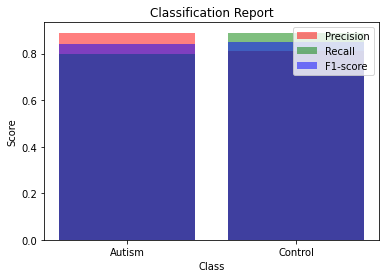

In [51]:
import matplotlib.pyplot as plt

precision = [0.89, 0.81]
recall = [0.80, 0.89]
f1_score = [0.84, 0.85]

x = ['Autism', 'Control']

plt.bar(x, precision, color='red', alpha=0.5, label='Precision')
plt.bar(x, recall, color='green', alpha=0.5, label='Recall')
plt.bar(x, f1_score, color='blue', alpha=0.5, label='F1-score')

plt.title('Classification Report')
plt.xlabel('Class')
plt.ylabel('Score')
plt.legend()
plt.show()

confusion matrix

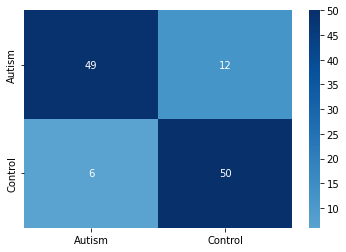

In [52]:
import seaborn as sns
CM = confusion_matrix(y_test_labels.argmax(axis=1),
	prediction.argmax(axis=1))
# drawing confusion matrix
sns.heatmap(CM, center = True , annot=True, fmt="d" ,cmap="Blues", xticklabels=classNames, yticklabels=classNames)
plt.show()

In [53]:
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
CM = confusion_matrix(y_test_labels.argmax(axis=1), prediction.argmax(axis=1))

# Calculate the true positives, true negatives, false positives, and false negatives
TP = CM[1,1]
TN = CM[0,0]
FP = CM[0,1]
FN = CM[1,0]

# Calculate the accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)
print("Accuracy of CNN:", accuracy*100)


Accuracy of CNN: 84.61538461538461


In [ ]:
# Comparitive analysis

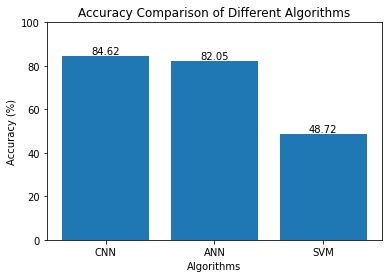

In [54]:
import matplotlib.pyplot as plt

algorithms = ['CNN', 'ANN', 'SVM']
accuracy_scores = [84.62, 82.05, 48.72]

fig, ax = plt.subplots()
rects = ax.bar(algorithms, accuracy_scores)

# Add labels above each bar
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

plt.title('Accuracy Comparison of Different Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.show()


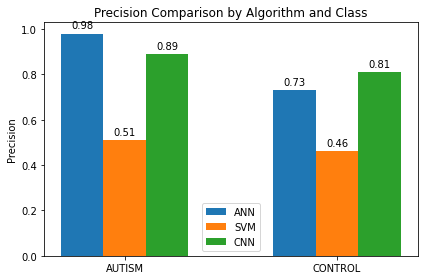

In [55]:
#precision comparision
import matplotlib.pyplot as plt
import numpy as np

# Precision scores for each algorithm and class
ann_precision = [0.98, 0.73]
svm_precision = [0.51, 0.46]
cnn_precision = [0.89, 0.81]

# Group labels and bar positions
labels = ['AUTISM', 'CONTROL']
x = np.arange(len(labels))
width = 0.2

# Create the figure and axes objects
fig, ax = plt.subplots()

# Plot the bars for each algorithm and class
rects1 = ax.bar(x - width, ann_precision, width, label='ANN')
rects2 = ax.bar(x, svm_precision, width, label='SVM')
rects3 = ax.bar(x + width, cnn_precision, width, label='CNN')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Precision')
ax.set_title('Precision Comparison by Algorithm and Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels to the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

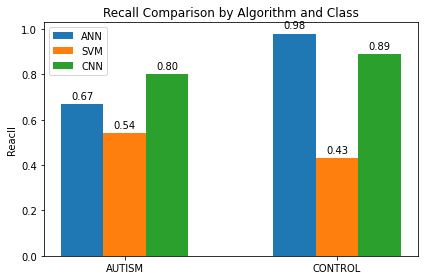

In [56]:
#Recall comparision
import matplotlib.pyplot as plt
import numpy as np

# recall scores for each algorithm and class
ann_recall = [0.67, 0.98]
svm_recall = [0.54, 0.43]
cnn_recall = [0.80, 0.89]

# Group labels and bar positions
labels = ['AUTISM', 'CONTROL']
x = np.arange(len(labels))
width = 0.2

# Create the figure and axes objects
fig, ax = plt.subplots()

# Plot the bars for each algorithm and class
rects1 = ax.bar(x - width, ann_recall, width, label='ANN')
rects2 = ax.bar(x, svm_recall, width, label='SVM')
rects3 = ax.bar(x + width, cnn_recall, width, label='CNN')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Reacll')
ax.set_title('Recall Comparison by Algorithm and Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels to the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

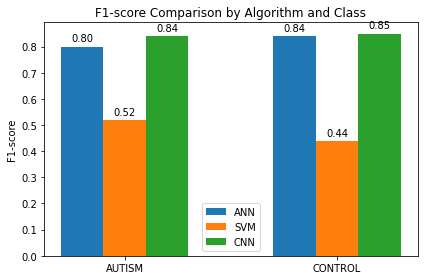

In [57]:
#f1-score comparision
import matplotlib.pyplot as plt
import numpy as np

# recall scores for each algorithm and class
ann_f1 = [0.80, 0.84]
svm_f1 = [0.52, 0.44]
cnn_f1 = [0.84, 0.85]

# Group labels and bar positions
labels = ['AUTISM', 'CONTROL']
x = np.arange(len(labels))
width = 0.2

# Create the figure and axes objects
fig, ax = plt.subplots()

# Plot the bars for each algorithm and class
rects1 = ax.bar(x - width, ann_f1, width, label='ANN')
rects2 = ax.bar(x, svm_f1, width, label='SVM')
rects3 = ax.bar(x + width, cnn_f1, width, label='CNN')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1-score')
ax.set_title('F1-score Comparison by Algorithm and Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels to the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

Prediction

In [58]:
def feature_extracte(input_path):
    time_series = masker.fit_transform(input_path)
    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    flattened_matrix = correlation_matrix.flatten('C')
    return flattened_matrix


In [59]:
# Normalize the data along the spatial dimensions
def display(input_path):
    nifti_img = nib.load(input_path)
    image_array = nifti_img.get_fdata()
    min_val = np.min(image_array[:,:,:,:])
    max_val = np.max(image_array[:,:,:,:])
    image_array = (image_array - min_val) / (max_val - min_val)

    # Extract the first volume (time frame)
    volume = image_array[:, :, :, 0]

    # Display the shape of the volume to make sure it's 3D
    print(volume.shape)
    plt.imshow(volume[:,:,28], cmap='gray')
    plt.show()

prediction using Ann

[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(64, 64, 29)


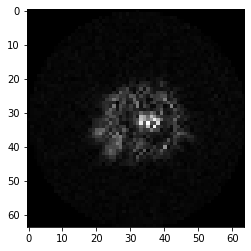

In [60]:
#standford control(tc-autism)
input_path = "E:/FYP-2023/Stanford/0051160/session_1/rest_1/rest.nii.gz"
feature_data = feature_extracte(input_path)
display(input_path)

In [61]:
feature_data = feature_data[:2000]
model_weight = load_model("E:/FYP-2023/ann_weight.h5")
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction.argmax()])

1/1 [==============================] - 0s 268ms/step
predicted label is: control


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(64, 64, 29)


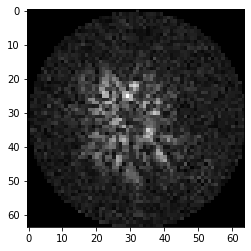

In [62]:
#standord-autism[tc autism]
input_path = 'E:/FYP-2023/Stanford/0051174/session_1/rest_1/rest.nii.gz'
feature_data = feature_extracte(input_path)
display(input_path)

In [63]:
feature_data = feature_data[:2000]
model_weight = load_model("E:/FYP-2023/ann_weight.h5")
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction.argmax()])

1/1 [==============================] - 0s 156ms/step
predicted label is: Autism 


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(64, 64, 29)


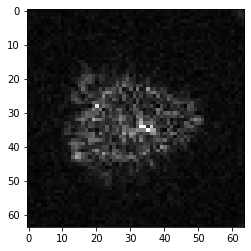

In [64]:
#standord-control[tc control]
input_path = 'E:/FYP-2023/Stanford/0051180/session_1/rest_1/rest.nii.gz'
feature_data = feature_extracte(input_path)
display(input_path)

In [65]:
feature_data = feature_data[:2000]
model_weight = load_model("E:/FYP-2023/ann_weight.h5")
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction.argmax()])

1/1 [==============================] - 0s 300ms/step
predicted label is: control


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {32, 40, 48}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


(64, 64, 34)


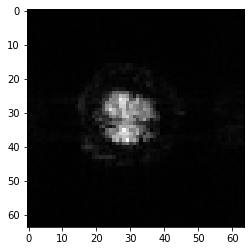

In [66]:
#caltech-autism[tc-autism]
input_path = "E:/FYP-2023/Caltech/0051461/session_1/rest_1/rest.nii.gz"
feature_data = feature_extracte(input_path)
display(input_path)

In [67]:
feature_data = feature_data[:2000]
model_weight = load_model("E:/FYP-2023/ann_weight.h5")
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction.argmax()])

1/1 [==============================] - 0s 230ms/step
predicted label is: Autism 


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(64, 64, 34)


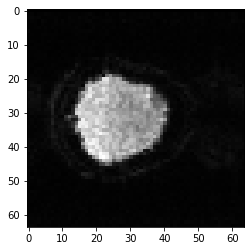

In [25]:
#caltech-control[tc-control]
input_path="E:/FYP-2023/Caltech/0051480/session_1/rest_1/rest.nii.gz"
feature_data = feature_extracte(input_path)
display(input_path)

In [26]:
feature_data = feature_data[:2000]
model_weight = load_model("E:/FYP-2023/ann_weight.h5")
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction.argmax()])

1/1 [==============================] - 0s 79ms/step
predicted label is: control


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
(64, 64, 29)


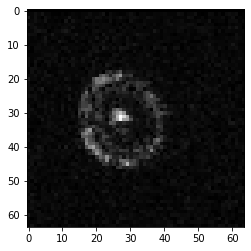

In [38]:
#olin-autism[tc-autism]
input_path="E:/FYP-2023/Olin/0050124/session_1/rest_1/rest.nii.gz"
feature_data = feature_extracte(input_path)
display(input_path)

In [39]:
feature_data = feature_data[:2000]
model_weight = load_model("E:/FYP-2023/ann_weight.h5")
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction.argmax()])

1/1 [==============================] - 0s 79ms/step
predicted label is: Autism 


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(64, 64, 29)


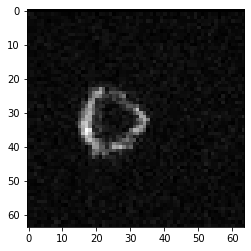

In [32]:
#olin-control[tc-control]
input_path="E:/FYP-2023/Olin/0050115/session_1/rest_1/rest.nii.gz"
feature_data = feature_extracte(input_path)
display(input_path)

In [34]:
feature_data = feature_data[:2000]
model_weight = load_model("E:/FYP-2023/ann_weight.h5")
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction.argmax()])

1/1 [==============================] - 0s 90ms/step
predicted label is: control


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(64, 64, 29)


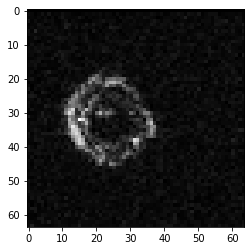

In [40]:
#olin-control[tc-autism]
input_path="E:/FYP-2023/Olin/0050123/session_1/rest_1/rest.nii.gz"
feature_data = feature_extracte(input_path)
display(input_path)

In [41]:
feature_data = feature_data[:2000]
model_weight = load_model("E:/FYP-2023/ann_weight.h5")
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction.argmax()])

1/1 [==============================] - 0s 80ms/step
predicted label is: control


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(64, 64, 42)


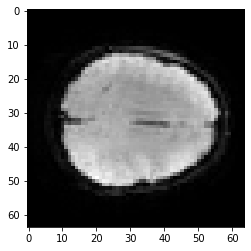

In [46]:
#SDSU-autism[tc-autism]
input_path="E:/FYP-2023/SDSU/0050188/session_1/rest_1/rest.nii.gz"
feature_data = feature_extracte(input_path)
display(input_path)

In [47]:
feature_data = feature_data[:2000]
model_weight = load_model("E:/FYP-2023/ann_weight.h5")
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction.argmax()])

1/1 [==============================] - 0s 79ms/step
predicted label is: Autism 


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(64, 64, 42)


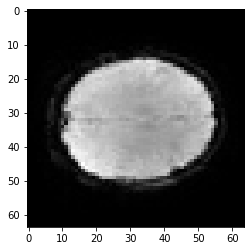

In [49]:
#SDSU-control[tc-control]
input_path="E:/FYP-2023/SDSU/0050199/session_1/rest_1/rest.nii.gz"
feature_data = feature_extracte(input_path)
display(input_path)

In [51]:
feature_data = feature_data[:2000]
model_weight = load_model("E:/FYP-2023/ann_weight.h5")
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction.argmax()])

1/1 [==============================] - 0s 79ms/step
predicted label is: control


Prediction using Svm model

[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(64, 64, 36)


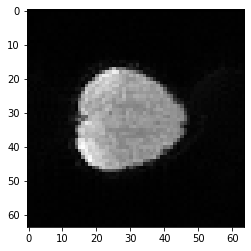

In [63]:
#ohsu-autism[tc-autism]
input_path = 'E:/FYP-2023/OHSU/0050153/session_1/rest_1/rest.nii.gz'
feature_data = feature_extracte(input_path)
display(input_path)

In [64]:
feature_data = feature_data[:2000]
model_weight = pickle.load(open("E:FYP-2023/svm_weight.p","rb"))
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction[0]])

predicted label is: Autism 


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(64, 64, 36)


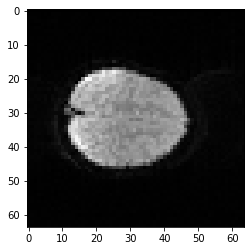

In [60]:
#ohsu-control[tc-control]
input_path = 'E:/FYP-2023/OHSU/0050169/session_1/rest_1/rest.nii.gz'
feature_data = feature_extracte(input_path)
display(input_path)

In [61]:
feature_data = feature_data[:2000]
model_weight = pickle.load(open("E:FYP-2023/svm_weight.p","rb"))
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction[0]])

predicted label is: control


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {48, 37, 14}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


(64, 64, 29)


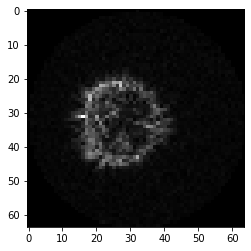

In [66]:
#stanford-autism[tc-autism]
input_path = 'E:/FYP-2023/Stanford/0051170/session_1/rest_1/rest.nii.gz'
feature_data = feature_extracte(input_path)
display(input_path)

In [67]:
feature_data = feature_data[:2000]
model_weight = pickle.load(open("E:FYP-2023/svm_weight.p","rb"))
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction[0]])

predicted label is: Autism 


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(64, 64, 29)


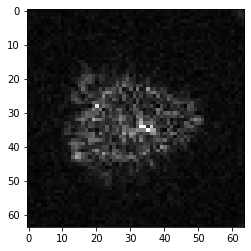

In [74]:
#Stanford-control[tc-control]
input_path = 'E:/FYP-2023/Stanford/0051180/session_1/rest_1/rest.nii.gz'
feature_data = feature_extracte(input_path)
display(input_path)

In [75]:
feature_data = feature_data[:2000]
model_weight = pickle.load(open("E:FYP-2023/svm_weight.p","rb"))
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction[0]])

predicted label is: control


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(80, 80, 38)


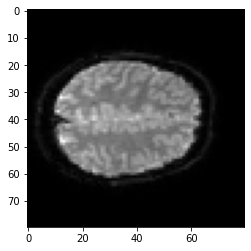

In [94]:
#sbl control[tc-control]
input_path = 'E:/FYP-2023/SBL/0051557/session_1/rest_1/rest.nii.gz'
feature_data = feature_extracte(input_path)
display(input_path)

In [95]:
feature_data = feature_data[:2000]
model_weight = pickle.load(open("E:FYP-2023/svm_weight.p","rb"))
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction[0]])

predicted label is: control


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
(80, 80, 38)


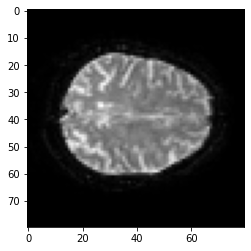

In [87]:
#sbl autism[tc-autism]
input_path = 'E:/FYP-2023/SBL/0051581/session_1/rest_1/rest.nii.gz'
feature_data = feature_extracte(input_path)
display(input_path)

In [88]:
feature_data = feature_data[:2000]
model_weight = pickle.load(open("E:FYP-2023/svm_weight.p","rb"))
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction[0]])

predicted label is: Autism 


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
(80, 80, 38)


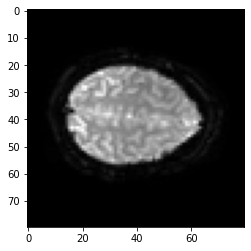

In [82]:
#sbl control[tc-autism]
input_path = 'E:/FYP-2023/SBL/0051571/session_1/rest_1/rest.nii.gz'
feature_data = feature_extracte(input_path)
display(input_path)

In [84]:
feature_data = feature_data[:2000]
model_weight = pickle.load(open("E:FYP-2023/svm_weight.p","rb"))
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction[0]])

predicted label is: control


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
(80, 80, 38)


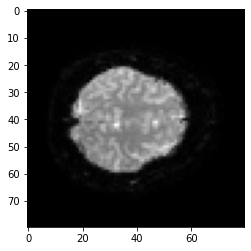

In [99]:
#trinity-autism[tc-autism]
input_path="E:/FYP-2023/Trinity/0050237/session_1/rest_1/rest.nii.gz"
feature_data = feature_extracte(input_path)
display(input_path)

In [100]:
feature_data = feature_data[:2000]
model_weight = pickle.load(open("E:FYP-2023/svm_weight.p","rb"))
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction[0]])

predicted label is: Autism 


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(80, 80, 38)


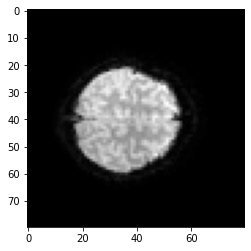

In [102]:
#Trinity-control[tc-control]
input_path="E:/FYP-2023/Trinity/0050269/session_1/rest_1/rest.nii.gz"
feature_data = feature_extracte(input_path)
display(input_path)

In [103]:
feature_data = feature_data[:2000]
model_weight = pickle.load(open("E:FYP-2023/svm_weight.p","rb"))
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction[0]])

predicted label is: control


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(64, 64, 34)


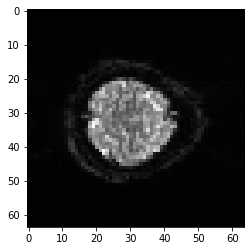

In [105]:
#Yale-autism[tc-autism]
input_path="E:/FYP-2023/Yale/0050614/session_1/rest_1/rest.nii.gz"
feature_data = feature_extracte(input_path)
display(input_path)

In [106]:
feature_data = feature_data[:2000]
model_weight = pickle.load(open("E:FYP-2023/svm_weight.p","rb"))
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction[0]])

predicted label is: Autism 


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
(64, 64, 34)


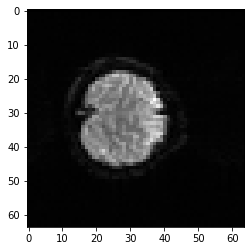

In [112]:
#yale-control[tc-control]
input_path="E:/FYP-2023/Yale/0050559/session_1/rest_1/rest.nii.gz"
feature_data = feature_extracte(input_path)
display(input_path)

In [113]:
feature_data = feature_data[:2000]
model_weight = pickle.load(open("E:FYP-2023/svm_weight.p","rb"))
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction[0]])

predicted label is: control


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
(64, 64, 29)


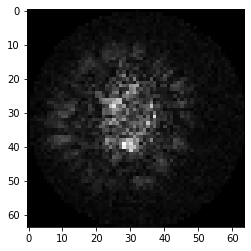

In [125]:
#stanford control[tc-autism]
input_path = "E:/FYP-2023/Stanford/0051179/session_1/rest_1/rest.nii.gz"
feature_data = feature_extracte(input_path)
display(input_path)

In [126]:
feature_data = feature_data[:2000]
model_weight = pickle.load(open("E:FYP-2023/svm_weight.p","rb"))
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction[0]])

predicted label is: control


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


Prediction using Cnn model

[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(64, 64, 29)


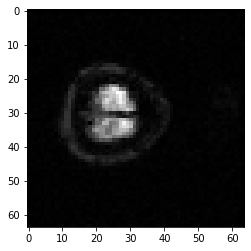

In [68]:
#pitt autism[tc-autism]
input_path = "E:/FYP-2023/Pitt/0050014/session_1/rest_1/rest.nii.gz"
feature_data = feature_extracte(input_path)
display(input_path)

In [69]:
feature_data = feature_data[:2000]
model_weight = load_model("E:/FYP-2023/cnn_weight.h5")
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction.argmax()])

1/1 [==============================] - 0s 240ms/step
predicted label is: Autism 


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(64, 64, 29)


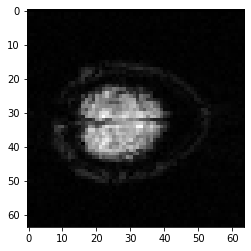

In [24]:
#Pitt control[tc-control]
input_path = "E:/FYP-2023/Pitt/0050030/session_1/rest_1/rest.nii.gz"
feature_data = feature_extracte(input_path)
display(input_path)

In [25]:
feature_data = feature_data[:2000]
model_weight = load_model("E:/FYP-2023/cnn_weight.h5")
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction.argmax()])

1/1 [==============================] - 0s 331ms/step
predicted label is: control


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


C:\Users\pooja\anaconda3\envs\tensorflow\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {48}. Label image only contains 48 labels (including background).
  warnings.warn("After resampling the label image to the "


(64, 64, 40)


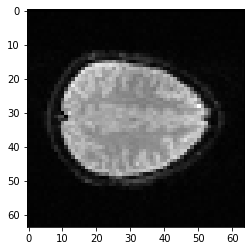

In [20]:
#usm-autism[tc-autism]
input_path = 'E:/FYP-2023/USM/0050477/session_1/rest_1/rest.nii.gz'
feature_data = feature_extracte(input_path)
display(input_path)

In [21]:
feature_data = feature_data[:2000]
model_weight = load_model("E:/FYP-2023/cnn_weight.h5")
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction.argmax()])

1/1 [==============================] - 1s 631ms/step
predicted label is: Autism 


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
(64, 64, 40)


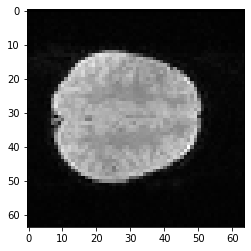

In [26]:
#usm-autism[tc-control]
input_path="E:/FYP-2023/USM/0050453/session_1/rest_1/rest.nii.gz"
feature_data = feature_extracte(input_path)
display(input_path)

In [27]:
feature_data = feature_data[:2000]
model_weight = load_model("E:/FYP-2023/cnn_weight.h5")
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction.argmax()])

1/1 [==============================] - 0s 307ms/step
predicted label is: Autism 


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(64, 64, 42)


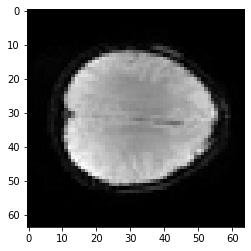

In [79]:
#usm-autism[tc-control]
input_path="E:/FYP-2023/SDSU/0050187/session_1/rest_1/rest.nii.gz"
feature_data = feature_extracte(input_path)
display(input_path)

In [80]:
feature_data = feature_data[:2000]
model_weight = load_model("E:/FYP-2023/cnn_weight.h5")
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction.argmax()])

1/1 [==============================] - 0s 283ms/step
predicted label is: Autism 


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(64, 64, 40)


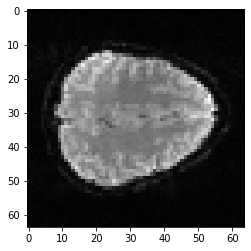

In [28]:
#usm-control[tc-control]
input_path="E:/FYP-2023/USM/0050432/session_1/rest_1/rest.nii.gz"
feature_data = feature_extracte(input_path)
display(input_path)

In [29]:
feature_data = feature_data[:2000]
model_weight = load_model("E:/FYP-2023/cnn_weight.h5")
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction.argmax()])

1/1 [==============================] - 0s 293ms/step
predicted label is: control


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(64, 64, 34)


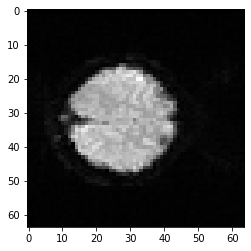

In [37]:
#ucla_1-autism[tc-autism]
input_path="E:/FYP-2023/UCLA_1/0051202/session_1/rest_1/rest.nii.gz"
feature_data = feature_extracte(input_path)
display(input_path)

In [38]:
feature_data = feature_data[:2000]
model_weight = load_model("E:/FYP-2023/cnn_weight.h5")
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction.argmax()])

1/1 [==============================] - 0s 303ms/step
predicted label is: Autism 


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(64, 64, 34)


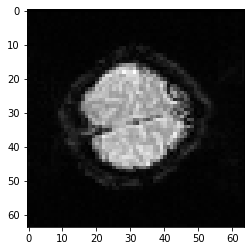

In [42]:
#ucla_1-control[tc-control]
input_path="E:/FYP-2023/UCLA_1/0051255/session_1/rest_1/rest.nii.gz"
feature_data = feature_extracte(input_path)
display(input_path)

In [43]:
feature_data = feature_data[:2000]
model_weight = load_model("E:/FYP-2023/cnn_weight.h5")
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction.argmax()])

1/1 [==============================] - 0s 300ms/step
predicted label is: control


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(96, 96, 47)


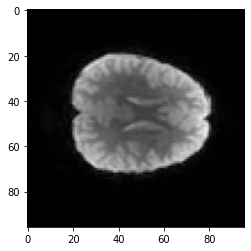

In [31]:
#kki-autism[tc-autism]
input_path="E:/FYP-2023/KKI/0050791/session_1/rest_1/rest.nii.gz"
feature_data = feature_extracte(input_path)
display(input_path)

In [32]:
feature_data = feature_data[:2000]
model_weight = load_model("E:/FYP-2023/cnn_weight.h5")
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction.argmax()])

1/1 [==============================] - 0s 266ms/step
predicted label is: Autism 


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(96, 96, 47)


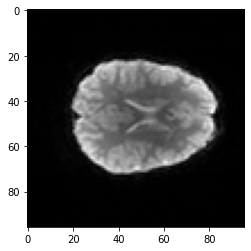

In [34]:
#kki-control[tc-control]
input_path="E:/FYP-2023/KKI/0050774/session_1/rest_1/rest.nii.gz"
feature_data = feature_extracte(input_path)
display(input_path)

In [35]:
feature_data = feature_data[:2000]
model_weight = load_model("E:/FYP-2023/cnn_weight.h5")
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction.argmax()])

1/1 [==============================] - 0s 309ms/step
predicted label is: control


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(64, 64, 34)


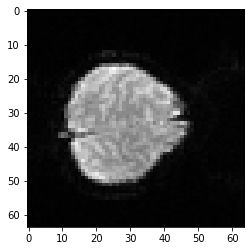

In [45]:
#ucla2-autism[tc-autism]
input_path="E:/FYP-2023/UCLA_2/0051294/session_1/rest_1/rest.nii.gz"
feature_data = feature_extracte(input_path)
display(input_path)

In [46]:
feature_data = feature_data[:2000]
model_weight = load_model("E:/FYP-2023/cnn_weight.h5")
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction.argmax()])

1/1 [==============================] - 0s 90ms/step
predicted label is: Autism 


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
(64, 64, 34)


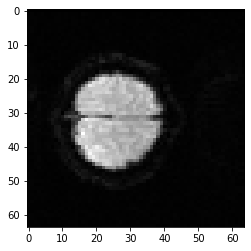

In [53]:
#ucla2-autism[tc-autism]
input_path="E:/FYP-2023/UCLA_2/0051301/session_1/rest_1/rest.nii.gz"
feature_data = feature_extracte(input_path)
display(input_path)

In [54]:
feature_data = feature_data[:2000]
model_weight = load_model("E:/FYP-2023/cnn_weight.h5")
prediction = model_weight.predict(feature_data.reshape(1,-1))
labels = ["Autism ","control"]
print("predicted label is:",labels[prediction.argmax()])

1/1 [==============================] - 0s 301ms/step
predicted label is: Autism 
